3d XRD feature extraction with fourier-based background subtraction

In [1]:
# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter as gf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

from xrdc.datasets import d3d
from xrdc import featurization as feat
from xrdc import source_separation as sep
from xrdc.dataproc.dataproc.operations import hitp

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)


In [2]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [3]:
from xrdc import peak_fitting as pf
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [4]:
debug = False

In [5]:
# %pdb

## 3D feature extraction

In [5]:
def get_coords(dgrid):
    coords = np.array([dgrid.coord(ii + 1) for ii in range(177)])
    return coords

swap3d = lambda arr: np.einsum("ijk->kij", arr)

def csim3d(activations_n1):
    #activations_n1 = swap3d(activations_n1)
    tmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

    norm = np.linalg.norm(activations_n1, axis = 0)

    norm4d = np.einsum("ij, kl->ijkl", norm, norm)

    tmp_csim = tmp / (norm4d + 1e-30)
    return tmp_csim

def gridstack(arr4d):
    return np.vstack(np.dstack(np.transpose(arr4d, (1, 0, 2, 3))))

def plot_clusters_grid(coords, clust, nclust):
    import matplotlib
    dim = coords.max()
    coordi = coords - 1
    hues = [float(float(x)/float(nclust)) for x in range(1,nclust+1)]
    cg = cluster_grid = np.zeros(shape = (dim,dim,3))
    for k, (x, y) in enumerate(coordi):
        cluster = clust[k]
        cluster_grid[x, y] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,1])
#     if debug:
#         print(coords)

#     fig = plt.figure()
#     fig.tight_layout()
    start, end = nclust - 1, nclust
    Big_labels = []
    Big_labels.append(clust)
    plt.imshow(cg)
    
def rmap(arr):
    """
    Map feature indices to random floats for visualization (temporary hack)
    """
    imax = arr.max()
    arr = arr.copy().astype(float)

    for i in range(1, imax + 1):
        new = np.random.random()
        arr[arr == i] = new
    return arr
 
# merge eventually into featurization.peakfit_featurize, needs to be more general to handle both 2 and 3-d arrays
def peakfit_featurize(patterns_pp, fitlists, size_thresh = 5, normf = feat.norm3d):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
        smooth_ax1 = 1,
        smooth_ax0 = 1, threshold_percentile = 50, thicken = True, size_thresh = size_thresh, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 1,
        thicken_ax1 = 0, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists,
    peakwidth = 1, normf = normf)
    return labeled, feature_masks, activations, norm_, activations_n1

In [6]:
# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

TODO run this on slow_T instead of patterns

In [14]:
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [ ]:
from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = True,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple')

# slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns)

# #background = sep.get_background(patterns, threshold = 25, smooth_q = 1.7, method = 'simple')
# background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, bg_fill_method = 'simple')

fsub_stop_2d = pf.curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 2)



(0, 0, 0)
numBlocks: 92, dataPts/Block: 8.695652173913043
[  0.  31.  87. 261. 304. 318. 377. 423. 516. 540. 655. 747. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31.,  87., 261., 304., 318., 377., 423., 516., 540., 655.,
       747., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 9, start iteration with error = 0.11721622817179589
Peak at 9, iteration 0: error = 0.12738946917145091
2.6176006806933616
Peak at 9, iteration 1: error = 0.01092020322374601
0.2947090918580804
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, start iteration with error = 0.22678112845390988
Peak at 59, iteration 0: error = 0.0535526669199191
0.1521349928529001
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workf

 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 287, start iteration with error = 0.6509550614488739
Peak at 287, iteration 0: error = 0.33359994473697385
0.4570694412564179
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 314, start iteration with error = 0.21153082133836143
Peak at 314, iteration 0: error = 0.06180411783452727
0.18713258892781065
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 389, start iteration with error = 0.12633118472042332
Peak at 389, iteration 0: error = 0.10935401316069095
1.4465173198780827
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 532, start iteration with error = 0.20050498340629153
Peak at 532, iteration 0: error = 0.06335002520114849
0.9742932046190896


 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 551, start iteration with error = 0.28174081198646456
Peak at 551, iteration 0: error = 0.147602881778885
4.589953367667264
Peak at 551, iteration 1: error = 0.10389360816880396
2.975535504108578
Peak at 551, iteration 2: error = 0.10389360816808059
                                                                                                                                                                                                                                                         Peak at 718, start iteration with error = 0.35307015395608954
Peak at 718, iteration 0: error = 0.12288160189465983
2.9524068072459912
Peak at 718, iteration 1: error = 0.10005751587569521
2.27435578659942
Peak at 718, iteration 2: error = 0.0652055077611317
     ----Saving data for block between 1.00 - 28.00
    ----Saving data for block between 29.00 - 90.00
    ----Saving 

    ----Saving data for block between 163.00 - 188.00
    ----Saving data for block between 189.00 - 230.00
    ----Saving data for block between 231.00 - 243.00
    ----Saving data for block between 244.00 - 293.00
    ----Saving data for block between 294.00 - 373.00
    ----Saving data for block between 374.00 - 465.00
    ----Saving data for block between 466.00 - 596.00
    ----Saving data for block between 597.00 - 607.00
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 93, dataPts/Block: 8.602150537634408
[  0.  27.  87. 262. 304. 318. 372. 424. 516. 567. 597. 654. 748. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  27.,  87., 262., 304., 318., 372., 424., 516., 567., 597.,
       654., 748., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 14, start iteration with error = 0.128640652162

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, start iteration with error = 0.1947878191348577
Peak at 59, iteration 0: error = 0.07108549314508236
1.1226431802962025
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 131, start iteration with error = 0.17443110334551176
Peak at 131, iteration 0: error = 0.0728052122964364
1.5859050676531468
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 287, start iteration with error = 0.3655044981970125
Peak at 287, iteration 0: error = 0.25277363397525277
1.0596737379316534
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 389, start iteration with error = 0.1488834764652711
Peak at 389, iteration 0: error = 0.061077591814351545
1.5859480882080168
 /home

    ----Saving data for block between 134.00 - 331.00
    ----Saving data for block between 332.00 - 374.00
    ----Saving data for block between 375.00 - 464.00
    ----Saving data for block between 465.00 - 549.00
    ----Saving data for block between 550.00 - 607.00
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  29.  85. 131. 331. 343. 465. 597. 608. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  29.,  85., 131., 331., 343., 465., 597., 608., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 12, start iteration with error = 0.11174940091784293
Peak at 12, iteration 0: error = 0.12028344908971271
6.334925863789151
Peak at 12, iteration 1: error = 0.011020553877251617
0.7258407483938689
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py

    ----Saving data for block between 92.00 - 136.00
    ----Saving data for block between 137.00 - 162.00
    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 264.00
    ----Saving data for block between 265.00 - 313.00
    ----Saving data for block between 314.00 - 378.00
    ----Saving data for block between 379.00 - 487.00
    ----Saving data for block between 488.00 - 513.00
    ----Saving data for block between 514.00 - 618.00
    ----Saving data for block between 619.00 - 761.00
    ----Saving data for block between 762.00 - 798.00
done
numBlocks: 87, dataPts/Block: 9.195402298850574
[  0.  91. 144. 190. 202. 266. 295. 314. 374. 459. 498. 619. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  91., 144., 190., 202., 266., 295., 314., 374., 459., 498.,
       619., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anacond

    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 243.00
    ----Saving data for block between 244.00 - 291.00
    ----Saving data for block between 292.00 - 314.00
    ----Saving data for block between 315.00 - 373.00
    ----Saving data for block between 374.00 - 458.00
    ----Saving data for block between 459.00 - 619.00
    ----Saving data for block between 620.00 - 798.00
done
numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  30.  90. 163. 190. 202. 244. 298. 369. 459. 646. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  30.,  90., 163., 190., 202., 244., 298., 369., 459., 646.,
       799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 10, start iteration with error = 0.11514828407014184
Peak at 10, itera

 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 310, start iteration with error = 0.17134606416292245
Peak at 310, iteration 0: error = 0.4512284570425882
2.19287655662355
Peak at 310, iteration 1: error = 0.01312363396072805
0.07254422791249292
/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 325, start iteration with error = 0.19147900151251554
Peak at 325, iteration 0: error = 0.16552497349207207
0.7352791140341677
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 388, start iteration with error = 0.1461128992522184
Peak at 388, iteration 0: error 

    ----Saving data for block between 88.00 - 260.00
    ----Saving data for block between 261.00 - 316.00
    ----Saving data for block between 317.00 - 467.00
    ----Saving data for block between 468.00 - 545.00
    ----Saving data for block between 546.00 - 653.00
    ----Saving data for block between 654.00 - 798.00
done
numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  30.  89. 134. 375. 466. 550. 656. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  30.,  89., 134., 375., 466., 550., 656., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 10, start iteration with error = 0.1426434880056081
Peak at 10, iteration 0: error = 0.06846765196846197
2.8869297845873203
Peak at 10, iteration 1: error = 0.019890115716154996
0.9552875763686544
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/d

    ----Saving data for block between 331.00 - 349.00
    ----Saving data for block between 350.00 - 466.00
    ----Saving data for block between 467.00 - 545.00
    ----Saving data for block between 546.00 - 607.00
    ----Saving data for block between 608.00 - 798.00
done
numBlocks: 100, dataPts/Block: 8.0
[  0.  29. 114. 135. 164. 196. 203. 281. 312. 376. 430. 454. 489. 522.
 574. 620. 631. 655. 764. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  29., 114., 135., 164., 196., 203., 281., 312., 376., 430.,
       454., 489., 522., 574., 620., 631., 655., 764., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 14, start iteration with error = 0.09183560998227114
Peak at 14, iteration 0: error = 0.16008074267809175
6.002022927663097
Peak at 14, iteration 1: error = 0.009776526876494154
0.45267091463443854
 /home/olli

    ----Saving data for block between 522.00 - 573.00
    ----Saving data for block between 574.00 - 619.00
    ----Saving data for block between 620.00 - 630.00
    ----Saving data for block between 631.00 - 654.00
    ----Saving data for block between 655.00 - 763.00
    ----Saving data for block between 764.00 - 798.00
done
numBlocks: 101, dataPts/Block: 7.920792079207921
[  0.  31.  92. 137. 163. 190. 232. 265. 315. 376. 430. 460. 514. 576.
 632. 762. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31.,  92., 137., 163., 190., 232., 265., 315., 376., 430.,
       460., 514., 576., 632., 762., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 19, start iteration with error = 0.16182691191468468
Peak at 19, iteration 0: error = 0.02163019740760406
0.4420709517830729
 /home/ollie/anaconda3/lib/python3.8/site-package

 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 301, start iteration with error = 0.5249818814825202
Peak at 301, iteration 0: error = 0.2978495993399162
7.062386996584171
Peak at 301, iteration 1: error = 0.10982300908099257
2.1665136191196877
Peak at 301, iteration 2: error = 0.08170992285551679
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 319, start iteration with error = 0.15280244266249277
Peak at 319, iteration 0: error = 0.12765232359467757
2.129323392461035
Peak at 319, iteration 1: error = 0.023449132441140157
1.1638762623553502
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 405, start iteration with error = 0.17184061426220137
Peak at 405, iteration 0: error = 0.09929497529456721
7.546489252768103
Peak at 405, iteration 1: error = 0.0511900902310326
3

    ----Saving data for block between 30.00 - 91.00
    ----Saving data for block between 92.00 - 161.00
    ----Saving data for block between 162.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 264.00
    ----Saving data for block between 265.00 - 294.00
    ----Saving data for block between 295.00 - 369.00
    ----Saving data for block between 370.00 - 457.00
    ----Saving data for block between 458.00 - 618.00
    ----Saving data for block between 619.00 - 734.00
    ----Saving data for block between 735.00 - 798.00
done
numBlocks: 84, dataPts/Block: 9.523809523809524
[  0.  29.  90. 162. 190. 202. 244. 296. 375. 458. 620. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  29.,  90., 162., 190., 202., 244., 296., 375., 458., 620.,
       799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dat

    ----Saving data for block between 232.00 - 292.00
    ----Saving data for block between 293.00 - 372.00
    ----Saving data for block between 373.00 - 459.00
    ----Saving data for block between 460.00 - 595.00
    ----Saving data for block between 596.00 - 798.00
done
numBlocks: 81, dataPts/Block: 9.876543209876543
[  0.  91. 264. 369. 464. 598. 648. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  91., 264., 369., 464., 598., 648., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, start iteration with error = 0.20084023356078076
Peak at 59, iteration 0: error = 0.06986272109440338
2.0148857160142892
Peak at 59, iteration 1: error = 0.050675269347160594
1.1318268828921711
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 125, start iter

    ----Saving data for block between 254.00 - 358.00
    ----Saving data for block between 359.00 - 467.00
    ----Saving data for block between 468.00 - 546.00
    ----Saving data for block between 547.00 - 655.00
    ----Saving data for block between 656.00 - 798.00
done
numBlocks: 86, dataPts/Block: 9.30232558139535
[  0.  31.  89. 256. 369. 467. 547. 656. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31.,  89., 256., 369., 467., 547., 656., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 13, start iteration with error = 0.13746725628611767
Peak at 13, iteration 0: error = 0.05084850698954513
4.86624808708295
Peak at 13, iteration 1: error = 0.013257729063640086
1.7911529962213648
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, sta

    ----Saving data for block between 88.00 - 130.00
    ----Saving data for block between 131.00 - 335.00
    ----Saving data for block between 336.00 - 351.00
    ----Saving data for block between 352.00 - 469.00
    ----Saving data for block between 470.00 - 546.00
    ----Saving data for block between 547.00 - 608.00
    ----Saving data for block between 609.00 - 798.00
done
numBlocks: 79, dataPts/Block: 10.126582278481013
[  0.  33.  88. 133. 335. 353. 463. 550. 651. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  33.,  88., 133., 335., 353., 463., 550., 651., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 11, start iteration with error = 0.13906143564278978
Peak at 11, iteration 0: error = 0.1233962028648328
7.4630123005903775
Peak at 11, iteration 1: error = 0.02107791809614858
1.3882054898474978
 /home/oll

    ----Saving data for block between 30.00 - 115.00
    ----Saving data for block between 116.00 - 141.00
    ----Saving data for block between 142.00 - 164.00
    ----Saving data for block between 165.00 - 243.00
    ----Saving data for block between 244.00 - 283.00
    ----Saving data for block between 284.00 - 313.00
    ----Saving data for block between 314.00 - 375.00
    ----Saving data for block between 376.00 - 430.00
    ----Saving data for block between 431.00 - 453.00
    ----Saving data for block between 454.00 - 487.00
    ----Saving data for block between 488.00 - 524.00
    ----Saving data for block between 525.00 - 575.00
    ----Saving data for block between 576.00 - 583.00
    ----Saving data for block between 584.00 - 629.00
    ----Saving data for block between 630.00 - 673.00
    ----Saving data for block between 674.00 - 798.00
done
numBlocks: 100, dataPts/Block: 8.0
[  0.  30. 115. 139. 164. 190. 203. 277. 311. 373. 430. 461. 517. 579.
 631. 655. 799.]
True
Expe

                                                                                                                                                                                                                                                       Peak at 652, start iteration with error = 0.1885027606335129
Peak at 652, iteration 0: error = 0.09220107548327126
14.643815338638912
Peak at 652, iteration 1: error = 0.035619083751206586
4.392038676567949
Peak at 652, iteration 2: error = 0.023033230534288695
                                                                                                                                                                                                                                                        Peak at 742, start iteration with error = 0.2425402798952105
Peak at 742, iteration 0: error = 0.10437666272023355
3.211468627034372
Peak at 742, iteration 1: error = 0.0678646172316195
2.1549897139458154
Peak at 742, iteration 2: error = 0.06

    ----Saving data for block between 92.00 - 162.00
    ----Saving data for block between 163.00 - 189.00
    ----Saving data for block between 190.00 - 201.00
    ----Saving data for block between 202.00 - 243.00
    ----Saving data for block between 244.00 - 294.00
    ----Saving data for block between 295.00 - 374.00
    ----Saving data for block between 375.00 - 457.00
    ----Saving data for block between 458.00 - 564.00
    ----Saving data for block between 565.00 - 631.00
    ----Saving data for block between 632.00 - 734.00
    ----Saving data for block between 735.00 - 798.00
done
numBlocks: 86, dataPts/Block: 9.30232558139535
[  0.  29.  93. 265. 296. 368. 458. 596. 631. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  29.,  93., 265., 296., 368., 458., 596., 631., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


    ----Saving data for block between 91.00 - 258.00
    ----Saving data for block between 259.00 - 364.00
    ----Saving data for block between 365.00 - 464.00
    ----Saving data for block between 465.00 - 596.00
    ----Saving data for block between 597.00 - 608.00
    ----Saving data for block between 609.00 - 798.00
done
numBlocks: 86, dataPts/Block: 9.30232558139535
[  0.  90. 253. 365. 466. 550. 659. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  90., 253., 365., 466., 550., 659., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, start iteration with error = 0.20989147186812576
Peak at 59, iteration 0: error = 0.04829687349632196
0.47156047153830394
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 115, start iteration with error = 0

    ----Saving data for block between 549.00 - 653.00
    ----Saving data for block between 654.00 - 798.00
done
numBlocks: 81, dataPts/Block: 9.876543209876543
[  0.  89. 130. 372. 471. 597. 609. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  89., 130., 372., 471., 597., 609., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, start iteration with error = 0.1684265313479309
Peak at 59, iteration 0: error = 0.06887132041761157
1.7627605164406905
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 116, start iteration with error = 0.13344342300433726
Peak at 116, iteration 0: error = 0.11345635897469726
4.003916821397364
Peak at 116, iteration 1: error = 0.012429106421626236
0.5308666662342332
 /home/ollie/anaconda3/lib/python3.8/site-packages/

    ----Saving data for block between 143.00 - 203.00
    ----Saving data for block between 204.00 - 283.00
    ----Saving data for block between 284.00 - 314.00
    ----Saving data for block between 315.00 - 370.00
    ----Saving data for block between 371.00 - 430.00
    ----Saving data for block between 431.00 - 462.00
    ----Saving data for block between 463.00 - 583.00
    ----Saving data for block between 584.00 - 642.00
    ----Saving data for block between 643.00 - 672.00
    ----Saving data for block between 673.00 - 798.00
done
numBlocks: 96, dataPts/Block: 8.333333333333334
[  0.  31.  92. 136. 165. 204. 284. 314. 376. 431. 488. 525. 576. 618.
 643. 674. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31.,  92., 136., 165., 204., 284., 314., 376., 431., 488.,
       525., 576., 618., 643., 674., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/datapro

 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 201, start iteration with error = 0.15070668473798912
Peak at 201, iteration 0: error = 0.18058639686584488
3.175121388084634
Peak at 201, iteration 1: error = 0.012019028529075408
0.23678307581749386
/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 249, start iteration with error = 0.13179681130241025
Peak at 249, iteration 0: error = 0.04851509877227831
0.42417090201488544
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 301, start iteration with error = 0.615056882424334
Peak at 301, iteration 0: err

    ----Saving data for block between 29.00 - 91.00
    ----Saving data for block between 92.00 - 162.00
    ----Saving data for block between 163.00 - 188.00
    ----Saving data for block between 189.00 - 202.00
    ----Saving data for block between 203.00 - 265.00
    ----Saving data for block between 266.00 - 314.00
    ----Saving data for block between 315.00 - 374.00
    ----Saving data for block between 375.00 - 428.00
    ----Saving data for block between 429.00 - 457.00
    ----Saving data for block between 458.00 - 572.00
    ----Saving data for block between 573.00 - 629.00
    ----Saving data for block between 630.00 - 668.00
    ----Saving data for block between 669.00 - 798.00
done
numBlocks: 98, dataPts/Block: 8.16326530612245
[  0.  92. 162. 233. 244. 370. 430. 523. 567. 630. 669. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  92., 162., 233., 244., 370., 430., 523., 567., 630., 669.,
       799.])}
negative values in background-subtracted pattern. ta

    ----Saving data for block between 290.00 - 365.00
    ----Saving data for block between 366.00 - 429.00
    ----Saving data for block between 430.00 - 456.00
    ----Saving data for block between 457.00 - 558.00
    ----Saving data for block between 559.00 - 630.00
    ----Saving data for block between 631.00 - 654.00
    ----Saving data for block between 655.00 - 732.00
    ----Saving data for block between 733.00 - 798.00
done
numBlocks: 89, dataPts/Block: 8.98876404494382
[  0.  94. 265. 295. 375. 458. 536. 598. 631. 655. 725. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  94., 265., 295., 375., 458., 536., 598., 631., 655., 725.,
       799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 68, start iteration with error = 0.2654110719089519
Peak at 68, iteration 0: error = 0.11347056205728263
13.491154349914867


    ----Saving data for block between 262.00 - 295.00
    ----Saving data for block between 296.00 - 374.00
    ----Saving data for block between 375.00 - 462.00
    ----Saving data for block between 463.00 - 595.00
    ----Saving data for block between 596.00 - 642.00
    ----Saving data for block between 643.00 - 733.00
    ----Saving data for block between 734.00 - 798.00
done
numBlocks: 77, dataPts/Block: 10.38961038961039
[  0.  29.  93. 253. 292. 370. 391. 466. 596. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  29.,  93., 253., 292., 370., 391., 466., 596., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 13, start iteration with error = 0.14107942363281936
Peak at 13, iteration 0: error = 0.084676760614425
2.648330669637448
Peak at 13, iteration 1: error = 0.01558442289991842
0.6182290246120258
 /home/ollie

    ----Saving data for block between 364.00 - 464.00
    ----Saving data for block between 465.00 - 549.00
    ----Saving data for block between 550.00 - 605.00
    ----Saving data for block between 606.00 - 798.00
done
numBlocks: 83, dataPts/Block: 9.63855421686747
[  0.  87. 252. 365. 465. 549. 653. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  87., 252., 365., 465., 549., 653., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 59, start iteration with error = 0.19451565024681391
Peak at 59, iteration 0: error = 0.057250919996169
0.7029128749237562
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 114, start iteration with error = 0.08142036142071869
Peak at 114, iteration 0: error = 0.0834586816392543
2.914797081542462
Peak at 114, iterati

    ----Saving data for block between 87.00 - 128.00
    ----Saving data for block between 129.00 - 364.00
    ----Saving data for block between 365.00 - 466.00
    ----Saving data for block between 467.00 - 547.00
    ----Saving data for block between 548.00 - 651.00
    ----Saving data for block between 652.00 - 798.00
done
numBlocks: 78, dataPts/Block: 10.256410256410257
[  0.  89. 136. 369. 473. 598. 609. 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  89., 136., 369., 473., 598., 609., 799.])}
negative values in background-subtracted pattern. taking absolute value.
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 60, start iteration with error = 0.17240875318342497
Peak at 60, iteration 0: error = 0.059566872048008805
0.20666699918481
 /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
Peak at 116, start iteration with error = 0

    ----Saving data for block between 31.00 - 93.00
    ----Saving data for block between 94.00 - 142.00
    ----Saving data for block between 143.00 - 203.00
    ----Saving data for block between 204.00 - 284.00
    ----Saving data for block between 285.00 - 314.00
    ----Saving data for block between 315.00 - 375.00
    ----Saving data for block between 376.00 - 430.00
    ----Saving data for block between 431.00 - 462.00
    ----Saving data for block between 463.00 - 583.00
    ----Saving data for block between 584.00 - 642.00
    ----Saving data for block between 643.00 - 673.00
    ----Saving data for block between 674.00 - 798.00
done
numBlocks: 96, dataPts/Block: 8.333333333333334
[  0.  31. 116. 135. 164. 206. 283. 315. 372. 430. 461. 585. 643. 676.
 799.]
True
Experimental Info used: 

{'blockBounds': array([  0.,  31., 116., 135., 164., 206., 283., 315., 372., 430., 461.,
       585., 643., 676., 799.])}
negative values in background-subtracted pattern. taking absolute value

    ----Saving data for block between 163.00 - 204.00
    ----Saving data for block between 205.00 - 276.00
    ----Saving data for block between 277.00 - 369.00
    ----Saving data for block between 370.00 - 429.00
    ----Saving data for block between 430.00 - 459.00
    ----Saving data for block between 460.00 - 576.00
    ----Saving data for block between 577.00 - 642.00


In [11]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [16]:
fitlists = fsub_stop_2d[1]

nclust = 11# i = 2

path = "../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"

from data_grid import DataGrid

dgrid = d3d.dgrid

q = dgrid.data[1][:,0]
X = dgrid.get_data_array()
X /= X.sum(axis = 1)[:, None]

coords = get_coords(dgrid)   

ridges = feat.get_ridges(feat.preprocess(fast_q, smooth_ax1= .8, threshold_percentile = 50)[0], axis = 2,
                        fitlists = fitlists, peakwidth = 1)

arr, labeled = feat.refine_and_label(ridges, sizetype = 'count', size_thresh=50,
                                    thicken_ax1=0)
feature_masks = np.array([labeled == i for i in range(1, labeled.max() + 1)])

labeled, feature_masks, activations, _norm, activations_n1 = peakfit_featurize(fast_q, fitlists,
                                                                               size_thresh = 5)

# peakfit_featurize doesn't calculate activations correctly for 3d arrays,
# so do it manually here
# TODO
axis = 3
# activations = np.log(1 + (feature_masks * fast_q).sum(axis = axis))
activations = (feature_masks * fast_q).sum(axis = axis)
scale = np.mean(activations, axis = (1, 2))
# activations_n1 = activations / scale[:, None, None]
activations_n1 = feat.norm3d(activations)

mask = (patterns.sum(axis = 2) != 0)
fast_q_flat = fast_q[mask]

(177, 800)
using fitlists
3
3
3
using fitlists
3
3
3
31
-1.1814320017631317
-4.163316680529025


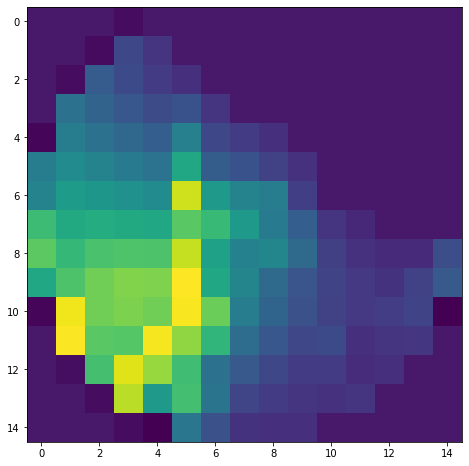

In [67]:
plt.imshow(activations[7])

In [42]:
reload(feat)
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

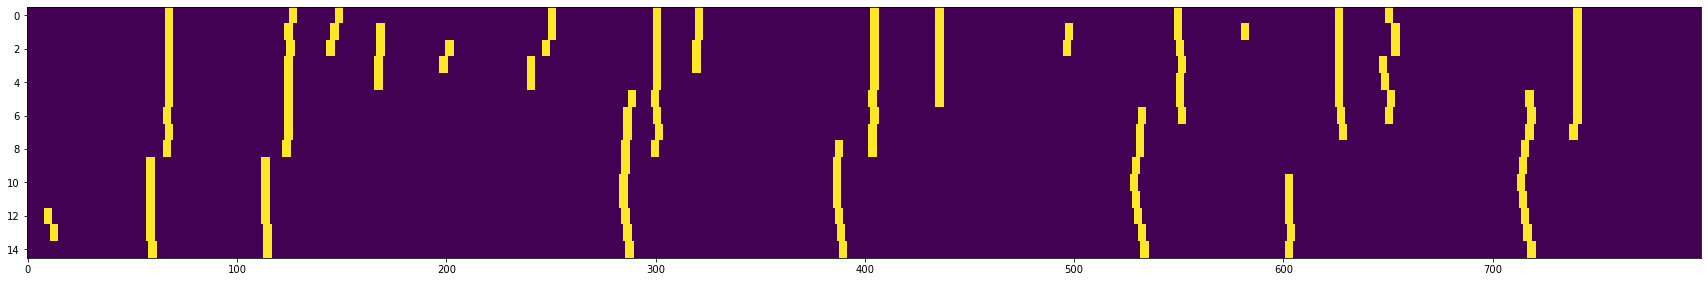

In [62]:
a,b = 3, 5
slice_peaks = feat.color_peaks_2d(fsub_stop_2d[1][5, :], patterns[5], fwhm_max = 20, area_min = 0, imin = 0,
                                 peakwidth = 2)
plt.imshow(slice_peaks, aspect=8, interpolation = 'none')

In [28]:
fsub_stop_2d[1][5, 3:5][1][0]

{'curve 0': {'FWHM': 6.115621155376653,
  'area': 255.61745757308748,
  'area_err': 1.3532148487807464e-06,
  'x0': 67.76790643950413},
 'curve 1': {'FWHM': 8.603445722883805,
  'area': -169.78699777238432,
  'area_err': 1.1241508681096698e-07,
  'x0': 60.8170955669961}}

In [58]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

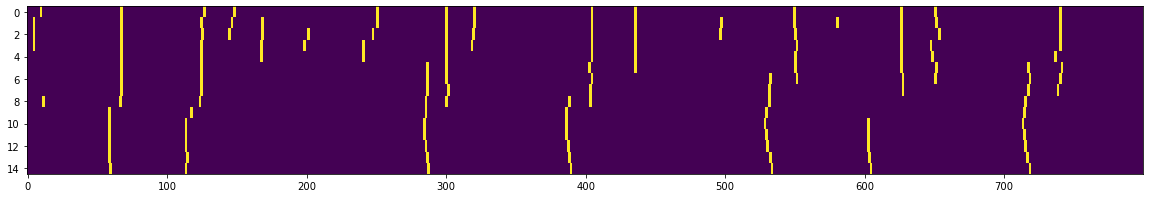

In [442]:
slice_peaks = feat.color_peaks_2d(fsub_stop_2d_2[1][5, :], patterns[5], fwhm_max = 20, area_min = 0, imin = 0,
                                 peakwidth = 1)
plt.imshow(slice_peaks, aspect=8, interpolation = 'none')

In [40]:
# def color_peaks_3d(patterns, peakparams, mask_zero = True, **kwargs):
#     """
#     Given peak fit parameters, return an array of the same shape as patterns with peak regions
#     set to 1.
#     """
#     res = np.array([feat.color_peaks_2d(params_slice, patterns_slice)
#                      for patterns_slice, params_slice in zip(patterns, peakparams)])
#     if mask_zero:
#         mask = (patterns.sum(axis = len(patterns.shape) - 1)) != 0
#         res *= mask[..., None]
#     return res

In [17]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [47]:
mask = (patterns.sum(axis = len(patterns.shape) - 1)) != 0
peakmask3d = feat.color_peaks_3d(fsub_stop_2d[1], fast_q)

In [156]:
# peakmask3d = color_peaks_3d(fast_q, fsub_stop_2d_3[1])

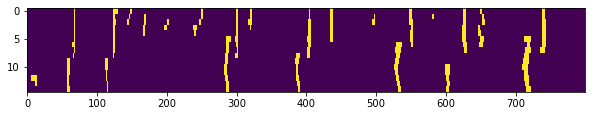

In [52]:
plt.imshow(peak_slices[5], aspect=8, interpolation = 'none')

In [10]:
def overlay_mask(img, mask, **kwargs):
    grayscale = 1 - mask
    alpha = mask
    rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
    plt.imshow(np.log(1 + img), cmap = 'jet', **kwargs)
    plt.imshow(rgb_img, cmap = 'Greys', **kwargs)

In [85]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

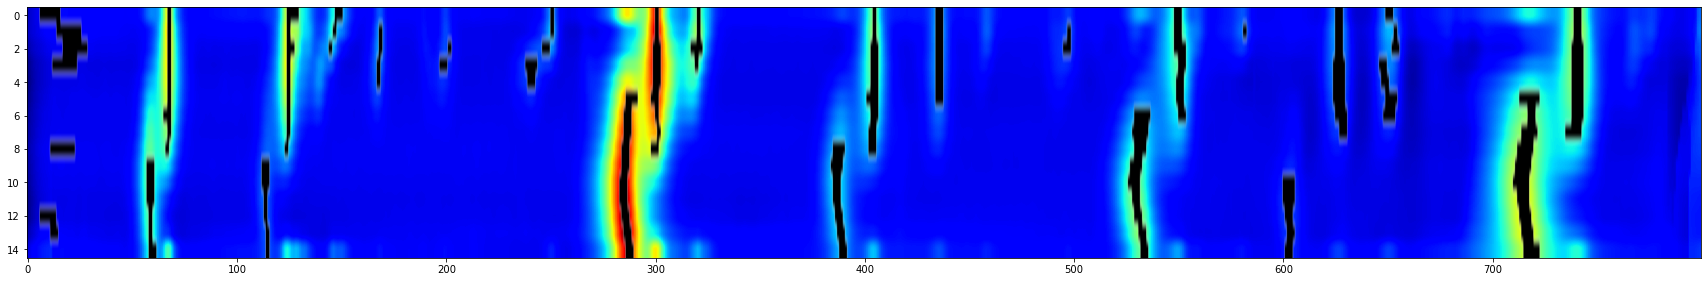

In [106]:
peak_slices = [feat.color_peaks_2d(fsub_stop_2d[1][i, :], patterns[i], fwhm_max = 80, imin = 0,
                                  peakwidth = 'auto')
              for i in range(patterns.shape[0])]

plt.rcParams["figure.figsize"]=(30, 30)
overlay_mask(fast_q[5], peak_slices[5], aspect = 8)

In [74]:
def plot_slices(callback, *args, N = 15, **kwargs):
    a, b = N, 1
    for i in range(N):
        plt.subplot(a, b, i + 1)
        plt.title('slice number {}'.format(i + 1), loc = 'right')
        callback(*(arg[i] for arg in args), **kwargs)
#        plt.imshow(np.log(1 + arr3d[:, i]), cmap = 'jet', interpolation = 'none')

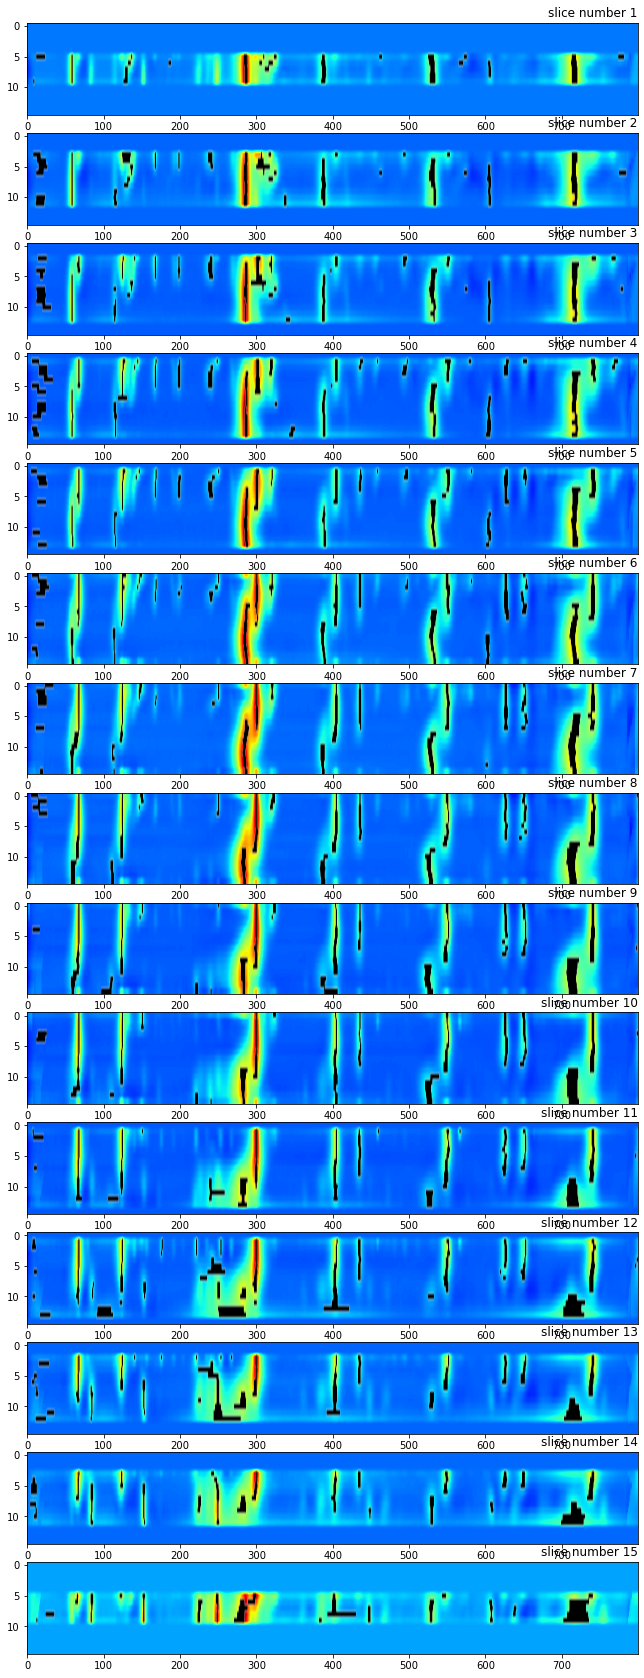

In [107]:
plot_slices(overlay_mask, fast_q * mask[..., None], peak_slices, aspect = 8, vmin = -1)#, vmax = np.log10(1 + fast_q.max()))

### TODO ask why number of peaks found depends on the intensity scale

In [18]:
patterns_pp = fast_q

In [21]:
import nibabel as nib

ModuleNotFoundError: No module named 'nibabel'

> <ipython-input-21-a6d1d588ad98>(1)<module>()
----> 1 import nibabel as nib

ipdb> c


In [20]:
from xrdc import visualization as vis

ModuleNotFoundError: No module named 'nibabel'

> /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py(2)<module>()
      1 from ipywidgets import interactive
----> 2 import nibabel as nib
      3 import k3d
      4 import math
      5 import numpy as np

ipdb> c


In [126]:
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

In [12]:
plot, volume = vis.heatmap3d(fast_q, interpolation = False);

Output()

In [101]:
import pathos

ModuleNotFoundError: No module named 'pathos'

> <ipython-input-101-93675a8f1721>(1)<module>()
----> 1 import pathos

ipdb> c


In [100]:
plot, volume = vis.heatmap3d(vfeats, interpolation = False, opacity_function = opacity_func,
                            color_range = color_range, scale = False, auto_color = False);

Output()

In [99]:
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

In [94]:
# # create opacity func
# opacity_func = np.zeros((256, 2), dtype=np.float32)
# opacity_func[:, 0] = tf.alpha.x /  max(tf.alpha.x) # rescale back between 0.0 and 1.0
# opacity_func[:, 1] = np.linspace(0, 1, 256)

vals = np.unique(vfeats.ravel())
vals.sort()
opacity_func = np.ones((len(vals), 2), dtype = np.float32)
opacity_func[:, 0] = vals
color_range = (np.min(vfeats), np.max(vfeats))

In [83]:
vfeats = (mask[..., None] * rmap(labeled))
volume.volume = vfeats

/Users/ollie/anaconda3/lib/python3.7/site-packages/k3d/objects.py:1175: UserWarning: wrong dtype: float64 ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


In [98]:
volume.volume = np.log(1 + 10 * fast_q / fast_q.max())

In [167]:
volume.volume = peakmask3d

In [363]:
%pdb

Automatic pdb calling has been turned ON


In [410]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [ ]:
mark

-4.163316680529025


(0.4323492203716807, 0.3893842895674234)

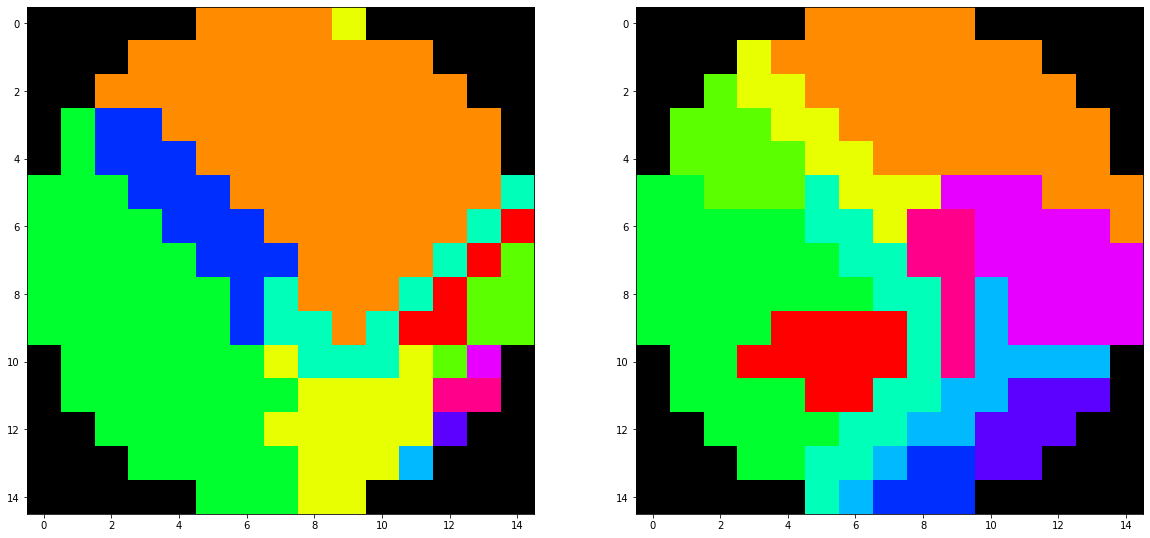

In [433]:
if debug:
    clust, sorter, clust_cms = feat.do_clust(patterns.T, nclust, ctype = 'agglom', linkage = 'average',
                                        affinity = 'cosine')
else:
    clust, sorter, clust_cms = feat.do_clust(fast_q_flat, activations[:, mask], nclust, ctype = 'agglom', linkage='average',
                                        affinity='cosine')


plt.subplot(1, 2, 1)
plot_clusters_grid(coords, clust, nclust)


plt.subplot(1, 2, 2)
plot_clusters_grid(get_coords(dgrid), y, 11)

# ax = fig.add_subplot(1,end-start,i-start+1)
# ax.imshow(cg)
# ax.invert_yaxis()
# ax.title.set_text(i)
# ax.axis("off")
# fig.show()

from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as rand

ami(y, clust), rand(y, clust)

In [424]:
activations.shape

(23, 15, 15)

In [409]:
patterns.shape

(15, 15, 800)

In [405]:
activations_n

(15, 15)

In [19]:
axis = 3
activations = np.log(1 + (feature_masks * patterns).sum(axis = axis))
#activations = (feature_masks * patterns).sum(axis = axis)
scale = np.mean(activations, axis = (1, 2))
# activations_n1 = activations / scale[:, None, None]
activations_n1 = feat.norm(activations)

mask = (patterns.sum(axis = 2) != 0)
patterns = patterns[mask]


/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py:136: RuntimeWarning: invalid value encountered in true_divide
  return ((arr - arr.mean(axis = axis)) / arr.std(axis = axis))


NameError: name 'dgrid' is not defined

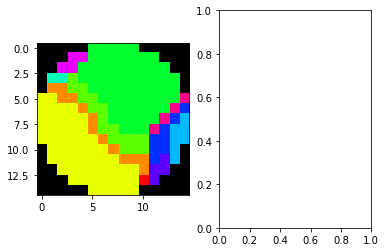

In [26]:
if debug:
    clust, sorter, clust_cms = feat.do_clust(patterns.T, nclust, ctype = 'agglom', linkage = 'average',
                                        affinity = 'cosine')
else:
    clust, sorter, clust_cms = feat.do_clust(patterns, activations[:, mask], nclust, ctype = 'agglom', linkage='average',
                                        affinity='cosine')


plt.subplot(1, 2, 1)
d3d.plot_clusters_grid(d3d.get_coords(d3d.dgrid), clust, nclust)


plt.subplot(1, 2, 2)
d3d.plot_clusters_grid(d3d.get_coords(dgrid), y, 11)

# ax = fig.add_subplot(1,end-start,i-start+1)
# ax.imshow(cg)
# ax.invert_yaxis()
# ax.title.set_text(i)
# ax.axis("off")
# fig.show()

from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as rand

ami(y, clust), rand(y, clust)

In [29]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .2, threshold = 50)

In [30]:
patterns.shape, m3d_agglom.shape

((177, 400), (15, 15, 400))

In [ ]:
max_ind = argrelextrema(orig, np.greater, axis = axis)
#     max_ind_2 = argrelextrema(orig, np.greater, axis = 0)
#     max_ind = np.hstack((max_ind[0], max_ind_2[0])), np.hstack((max_ind[1], max_ind_2[1]))

edges = np.zeros_like(orig)
edges[max_ind] = 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


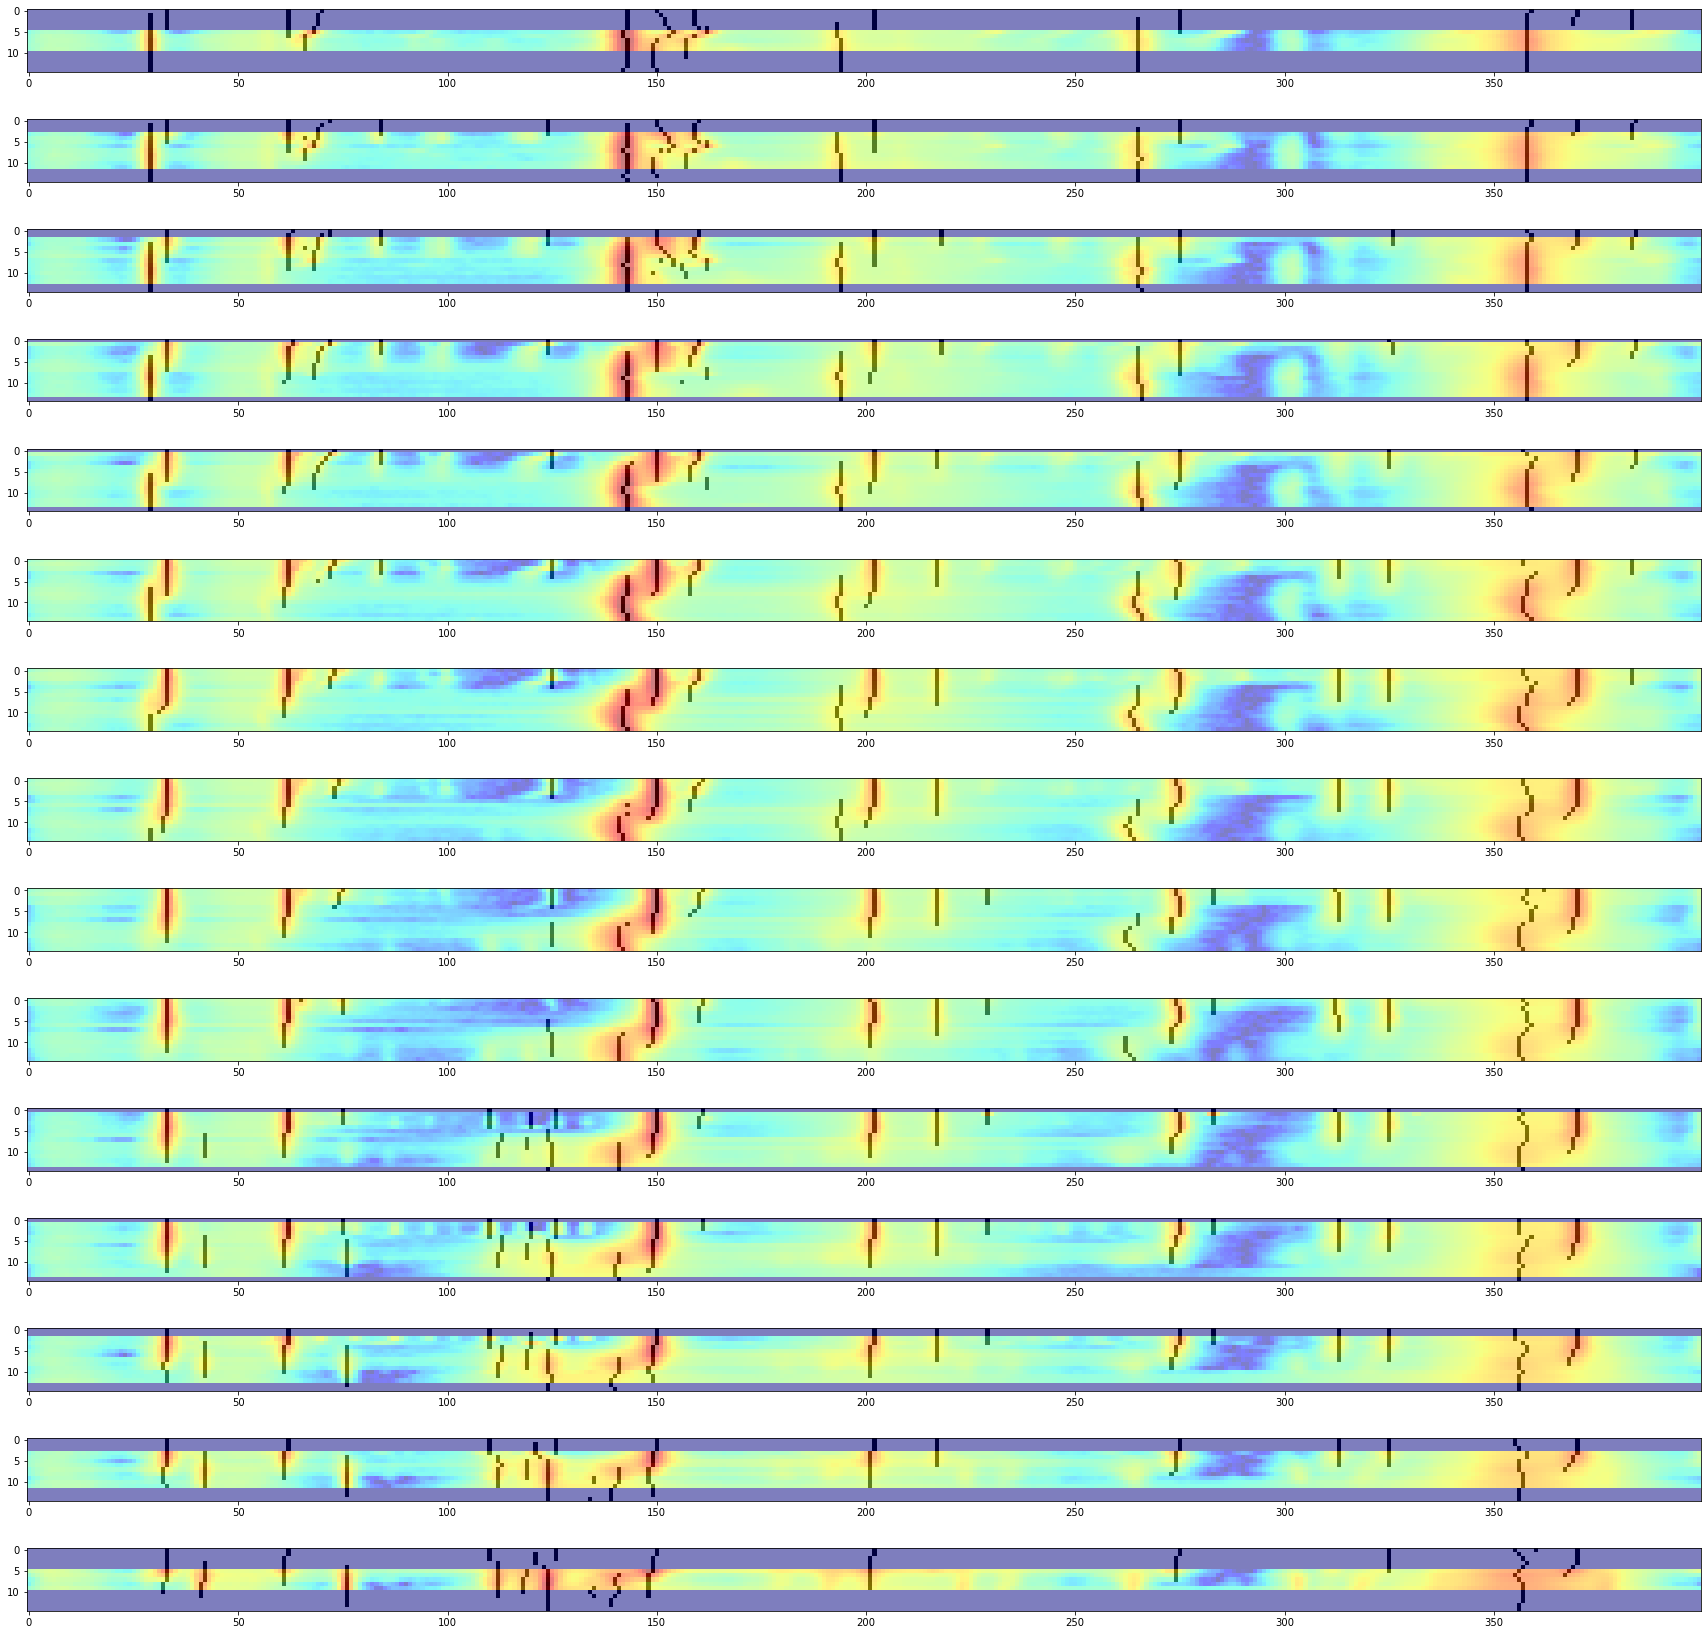

In [467]:
plt.rcParams["figure.figsize"]=(30, 30)

a, b = dim, 1

def plot_cuts(m3d_agglom, axis = 0, cmap = 'jet', **kwargs):
    for i in range(15):
        plt.subplot(a, b, i + 1)
        if axis == 0:
            plt.imshow(np.log(1 + m3d_agglom[i, :]), cmap = cmap, **kwargs)
        if axis == 1:
            plt.imshow(np.log(1 + m3d_agglom[:, i]), cmap = cmap, **kwargs)
plot_cuts(m3d_agglom)
plot_cuts(ridges, alpha = .5, cmap = 'Greys')

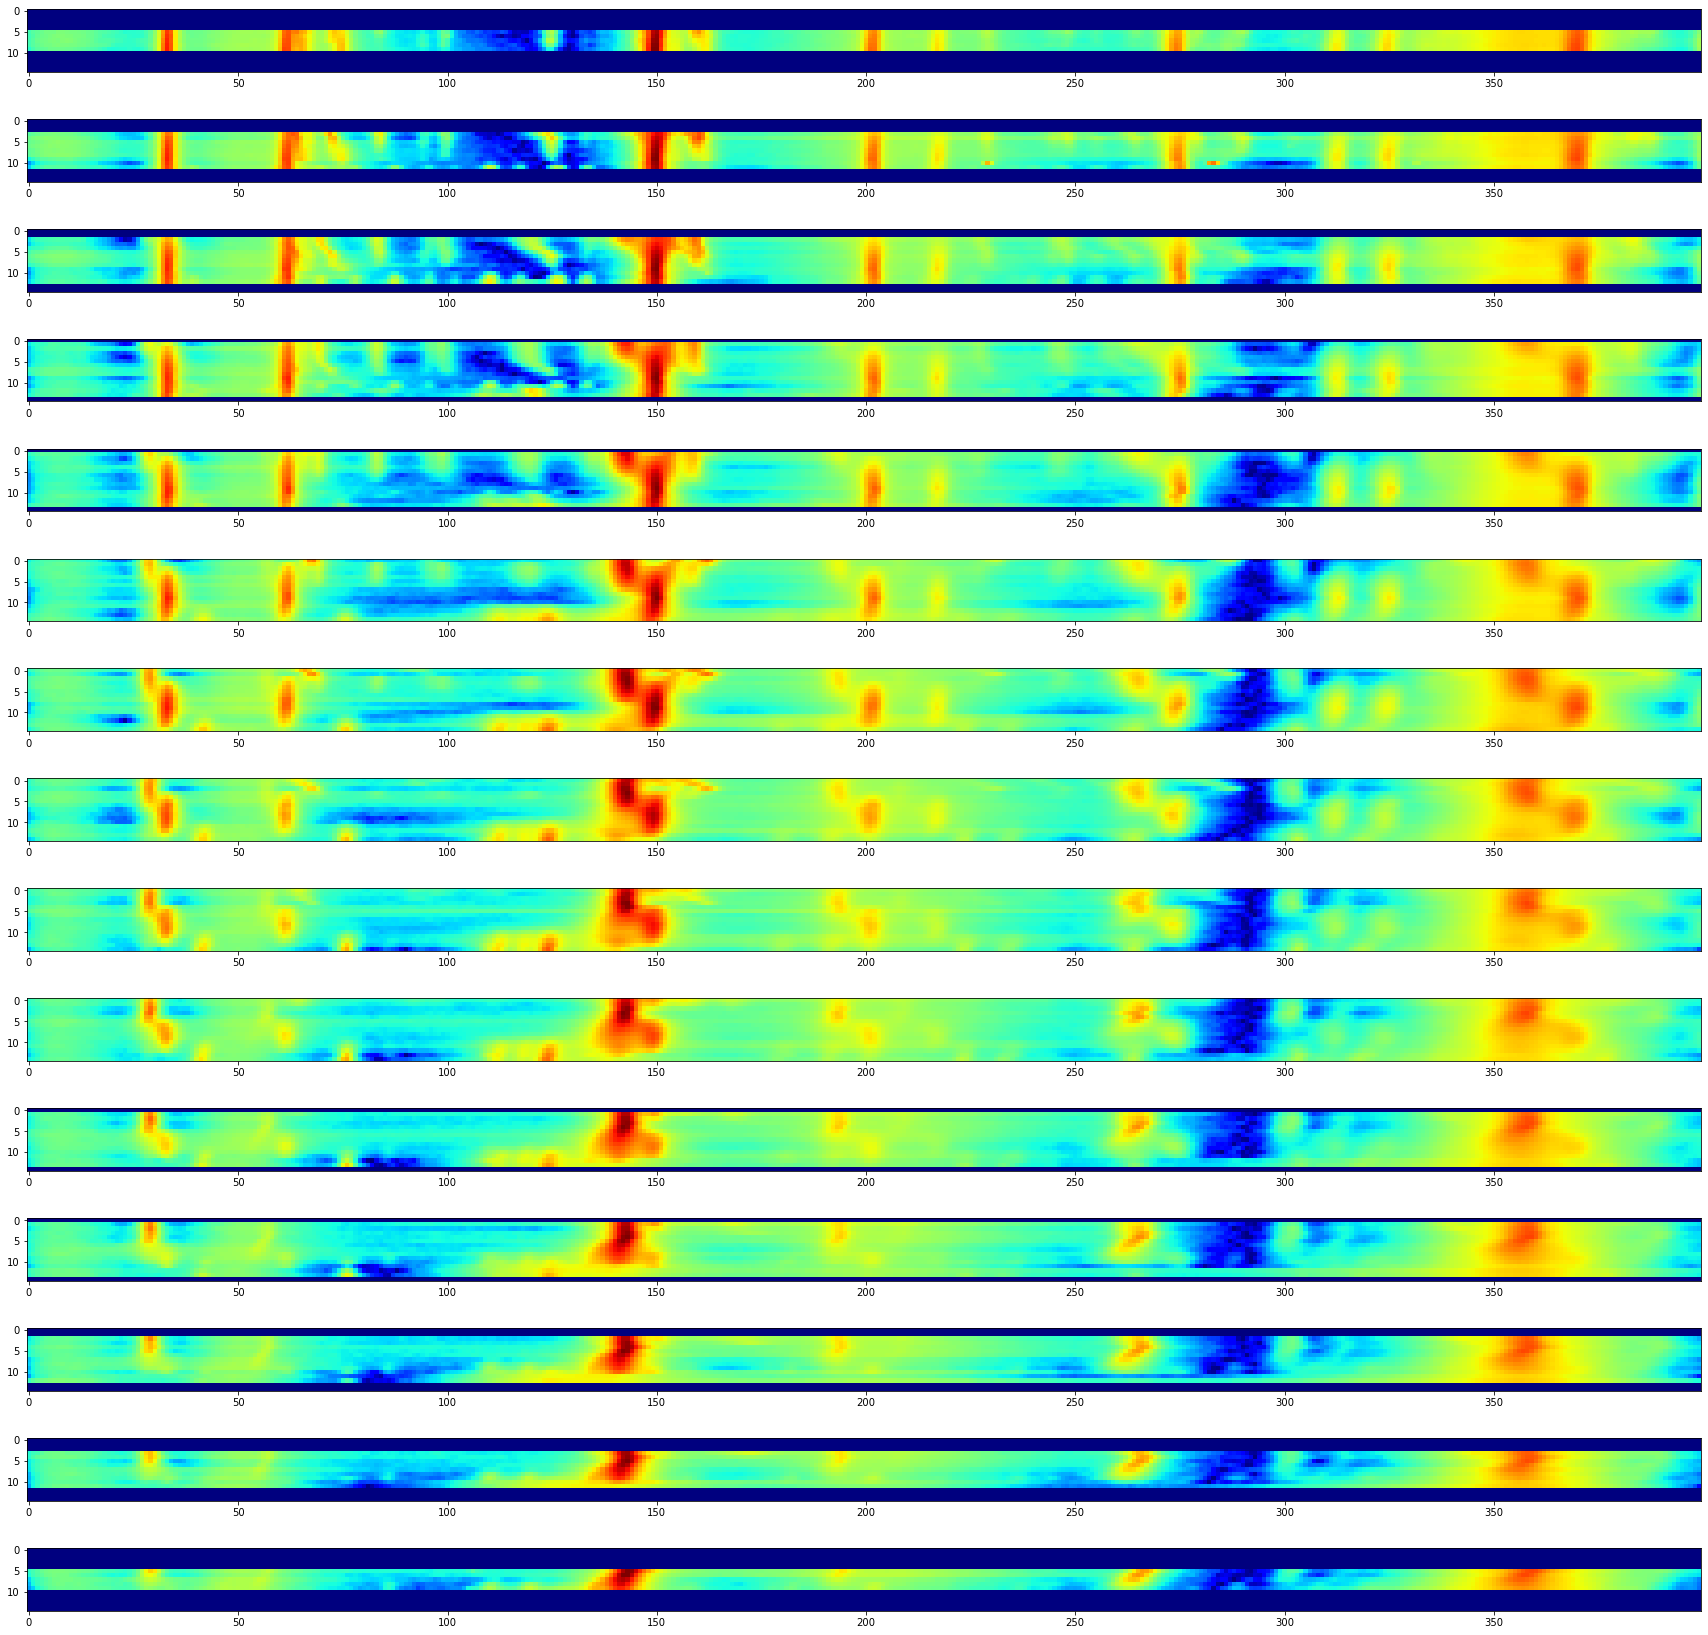

In [470]:
for i in range(15):
    plt.subplot(a, b, i + 1)
    plt.imshow(np.log(1 + m3d_agglom[:, i]), cmap = 'jet', interpolation = 'none')
# plot_cuts(ridges, alpha = .5, cmap = 'Greys')

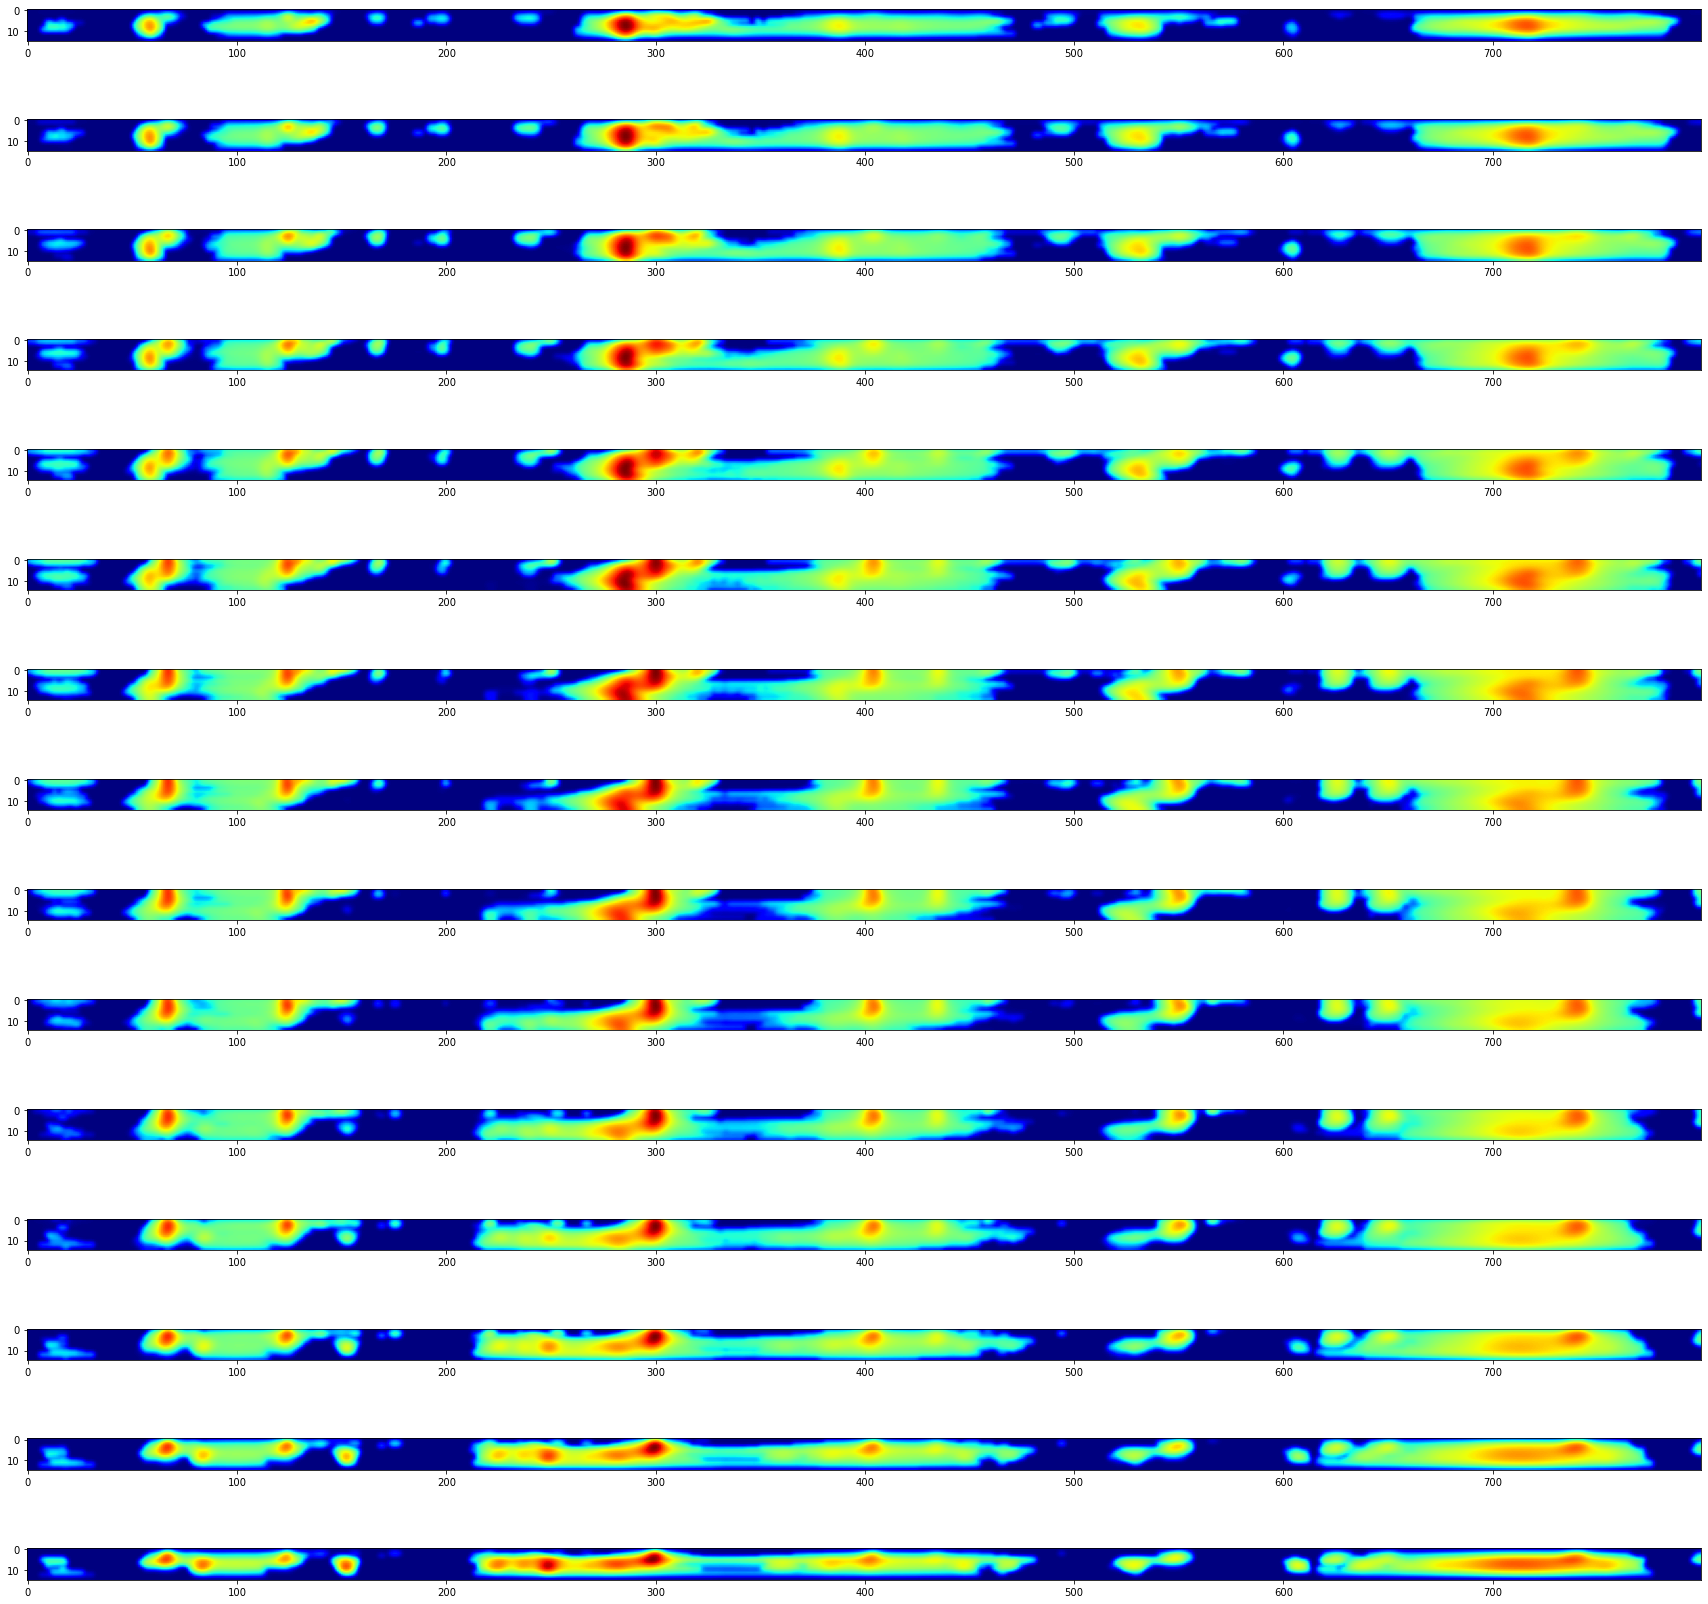

In [114]:
plot_cuts(preprocess(m3d, smooth = 1))

In [131]:
# m3d_agglom = m3d_agglom[:, :14]

In [210]:
m3d_agglom.shape

(15, 15, 400)

In [246]:
ridges.max()

1.0

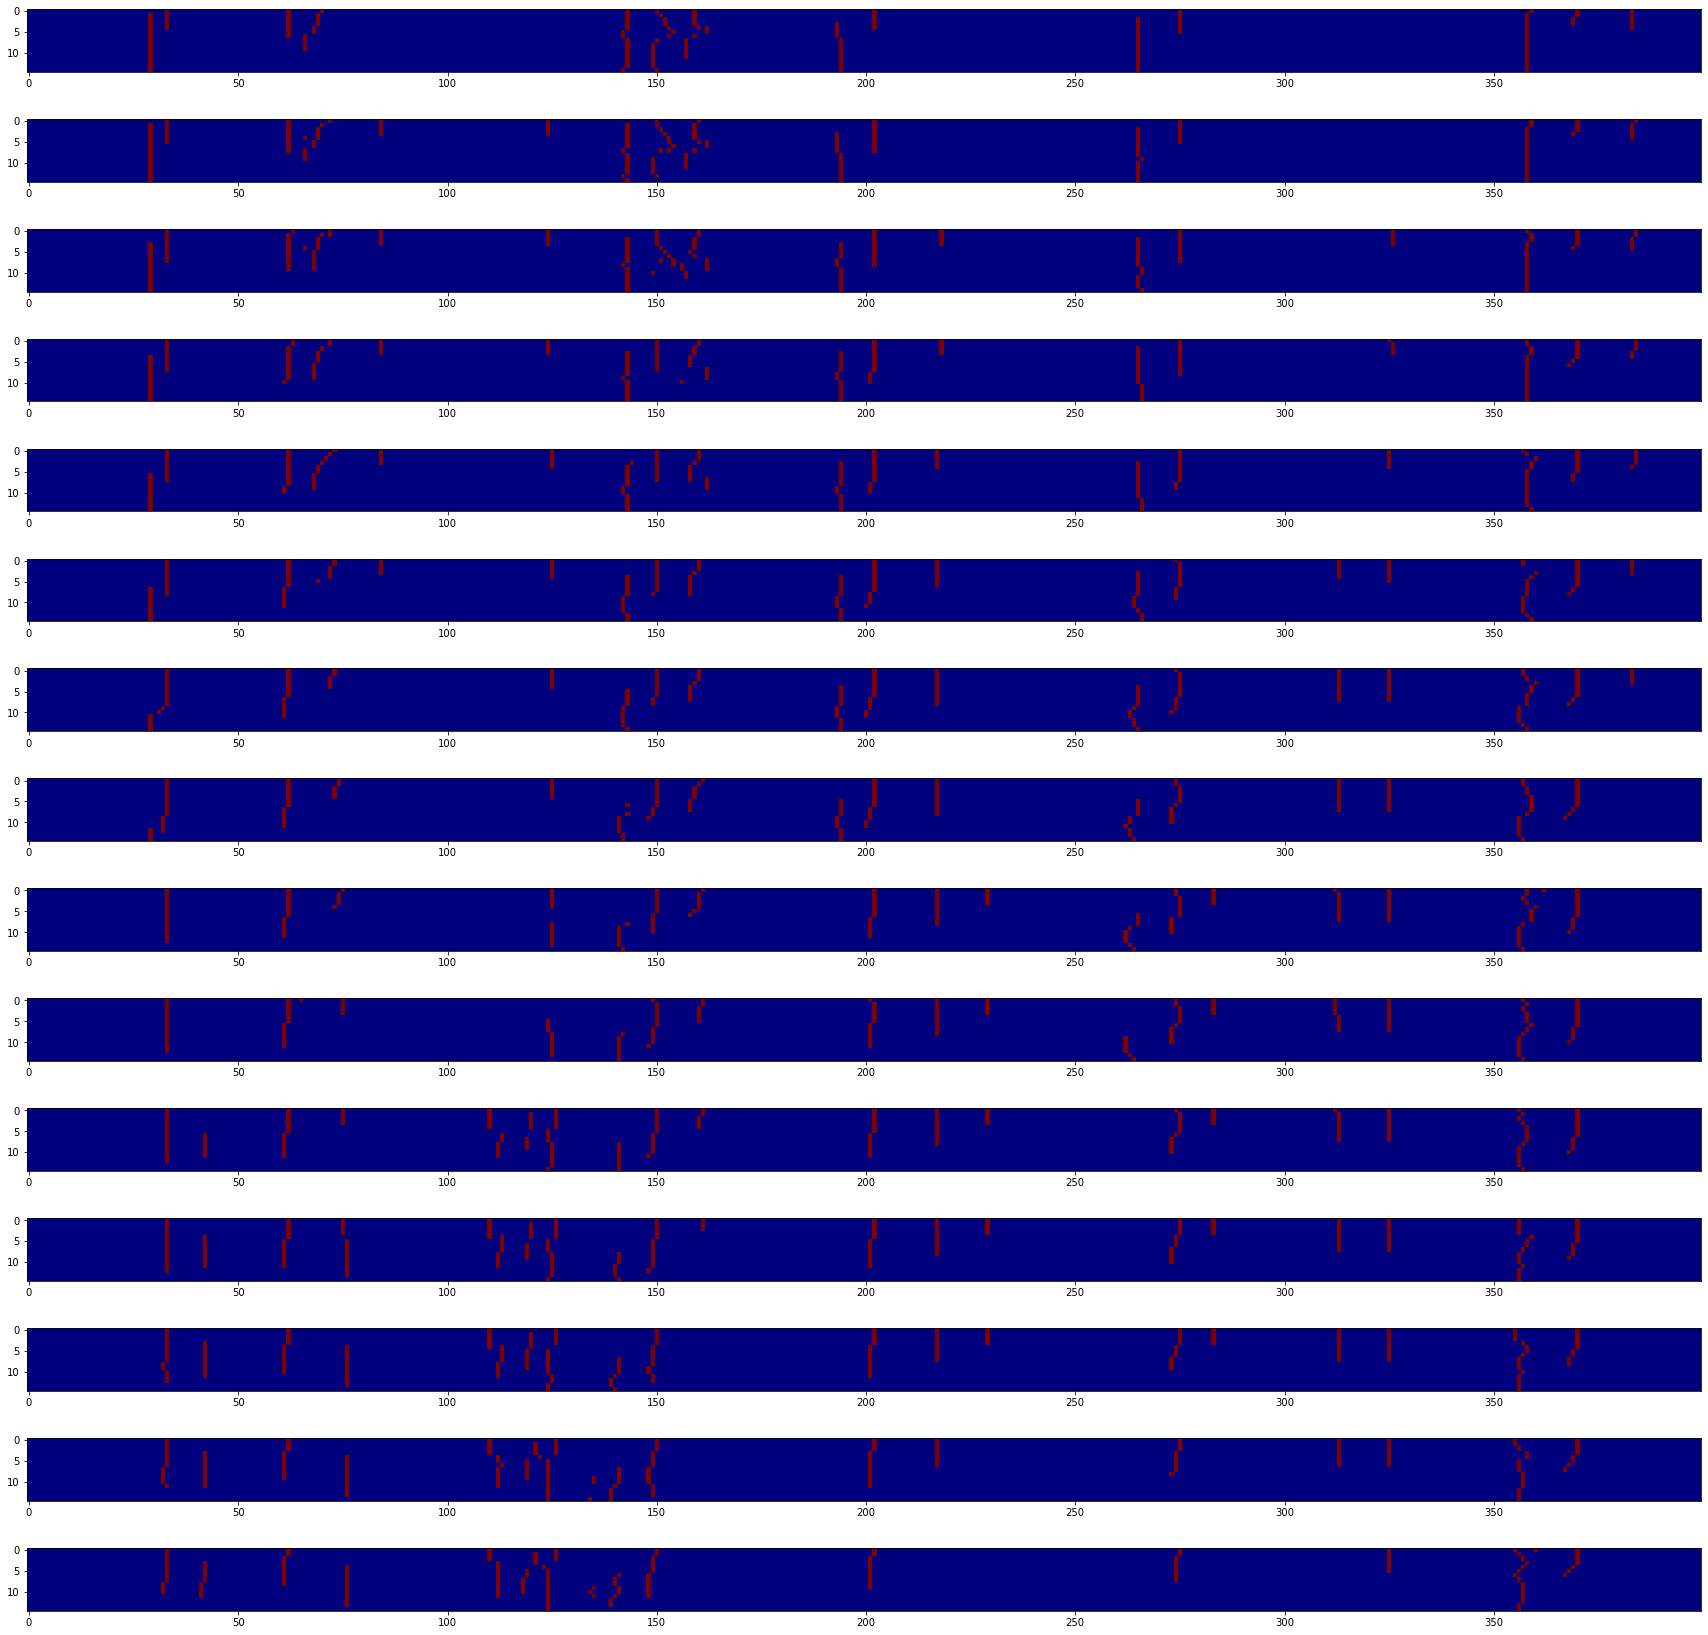

In [616]:
plot_cuts(ridges)

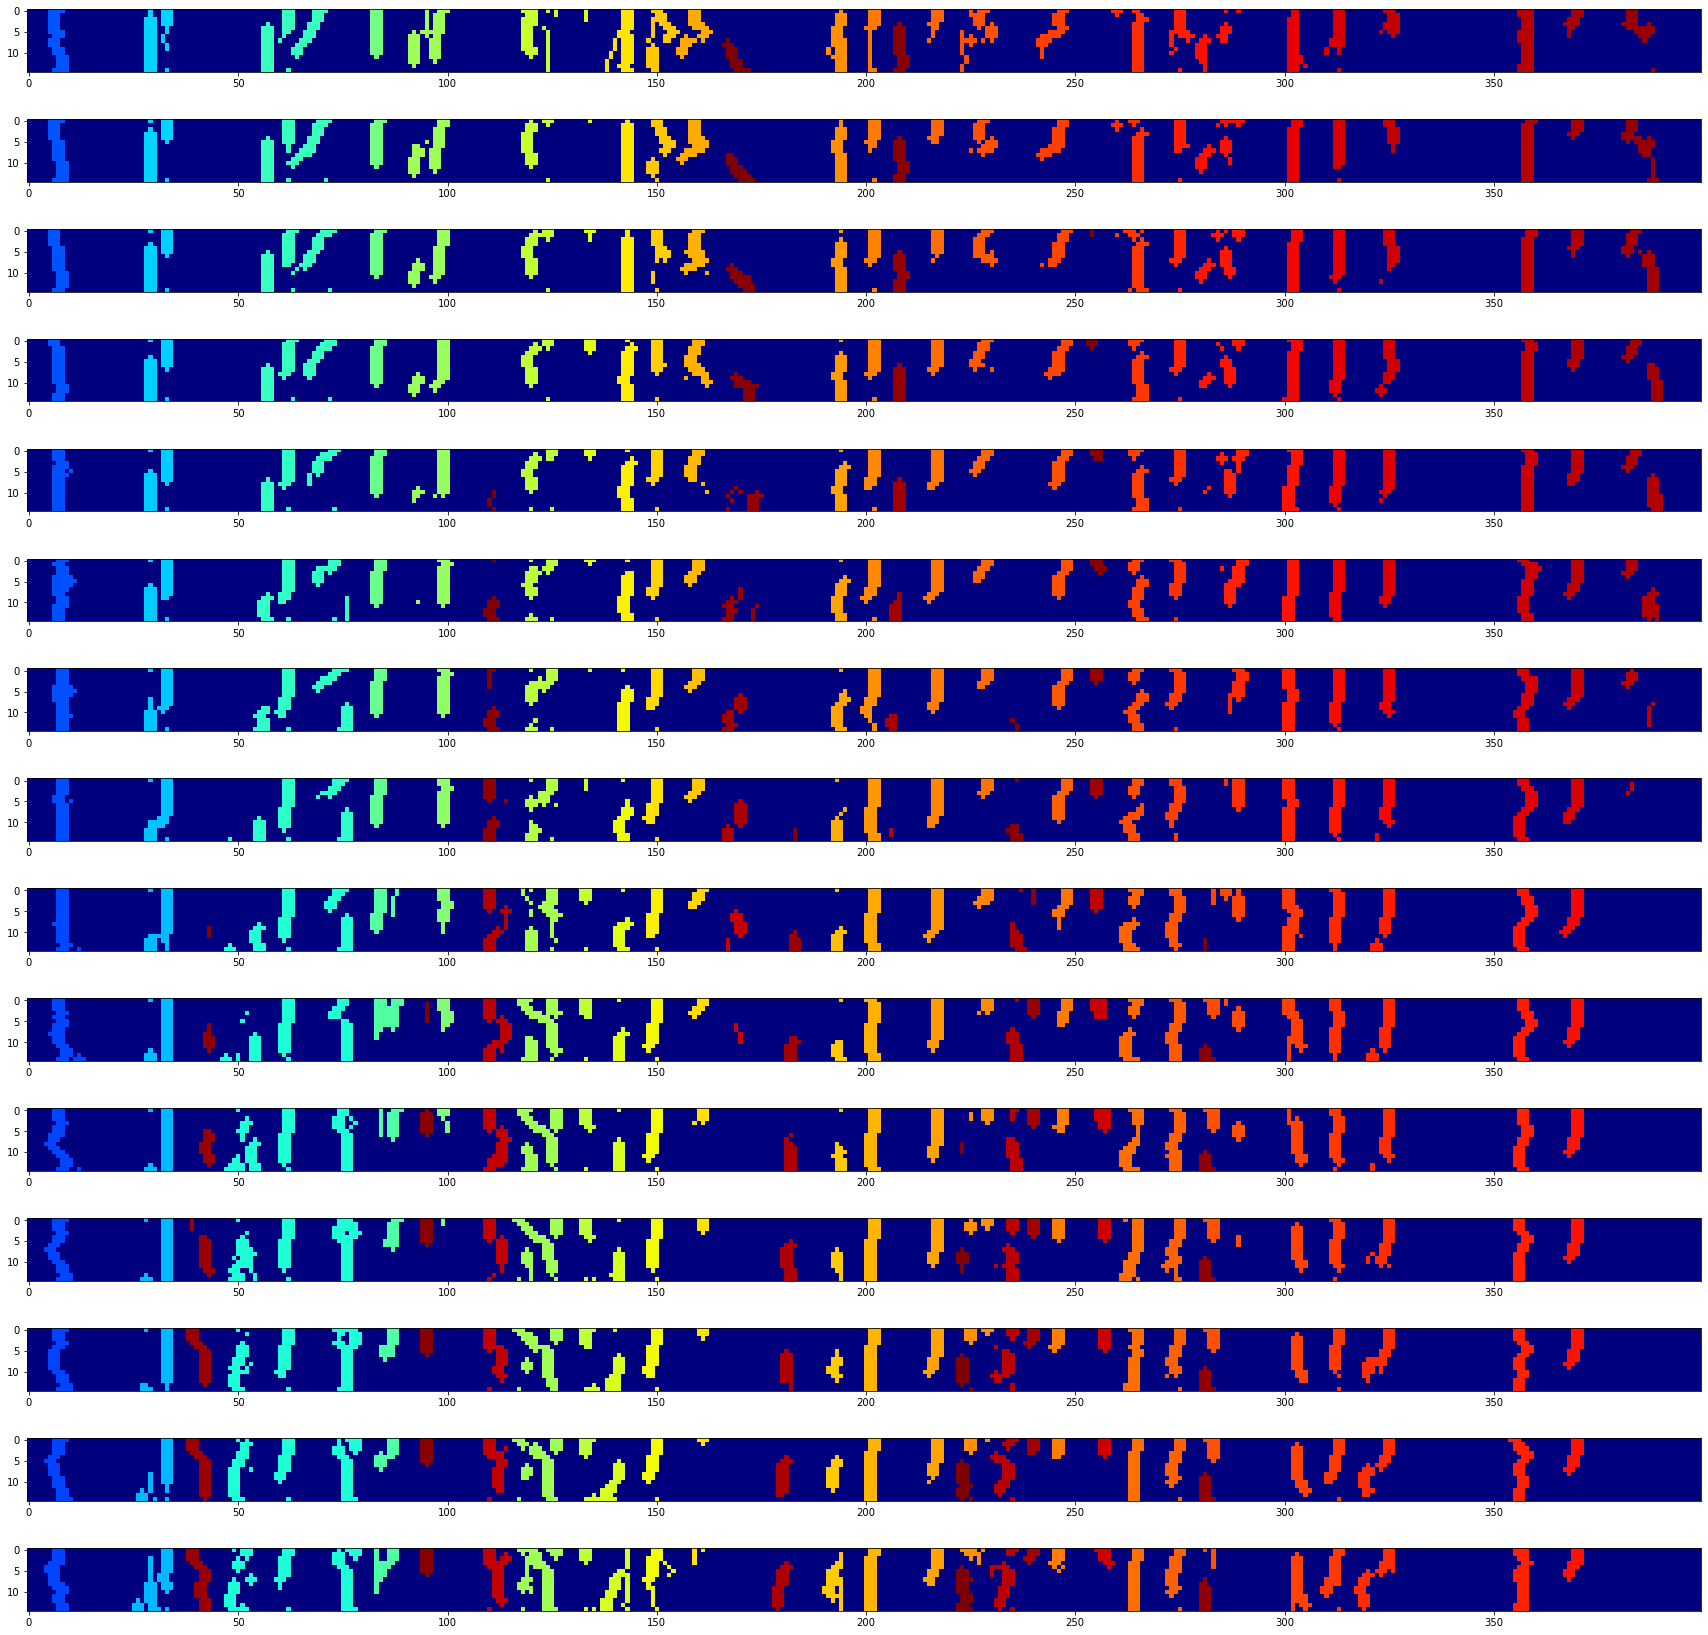

In [655]:
plot_cuts(labeled)

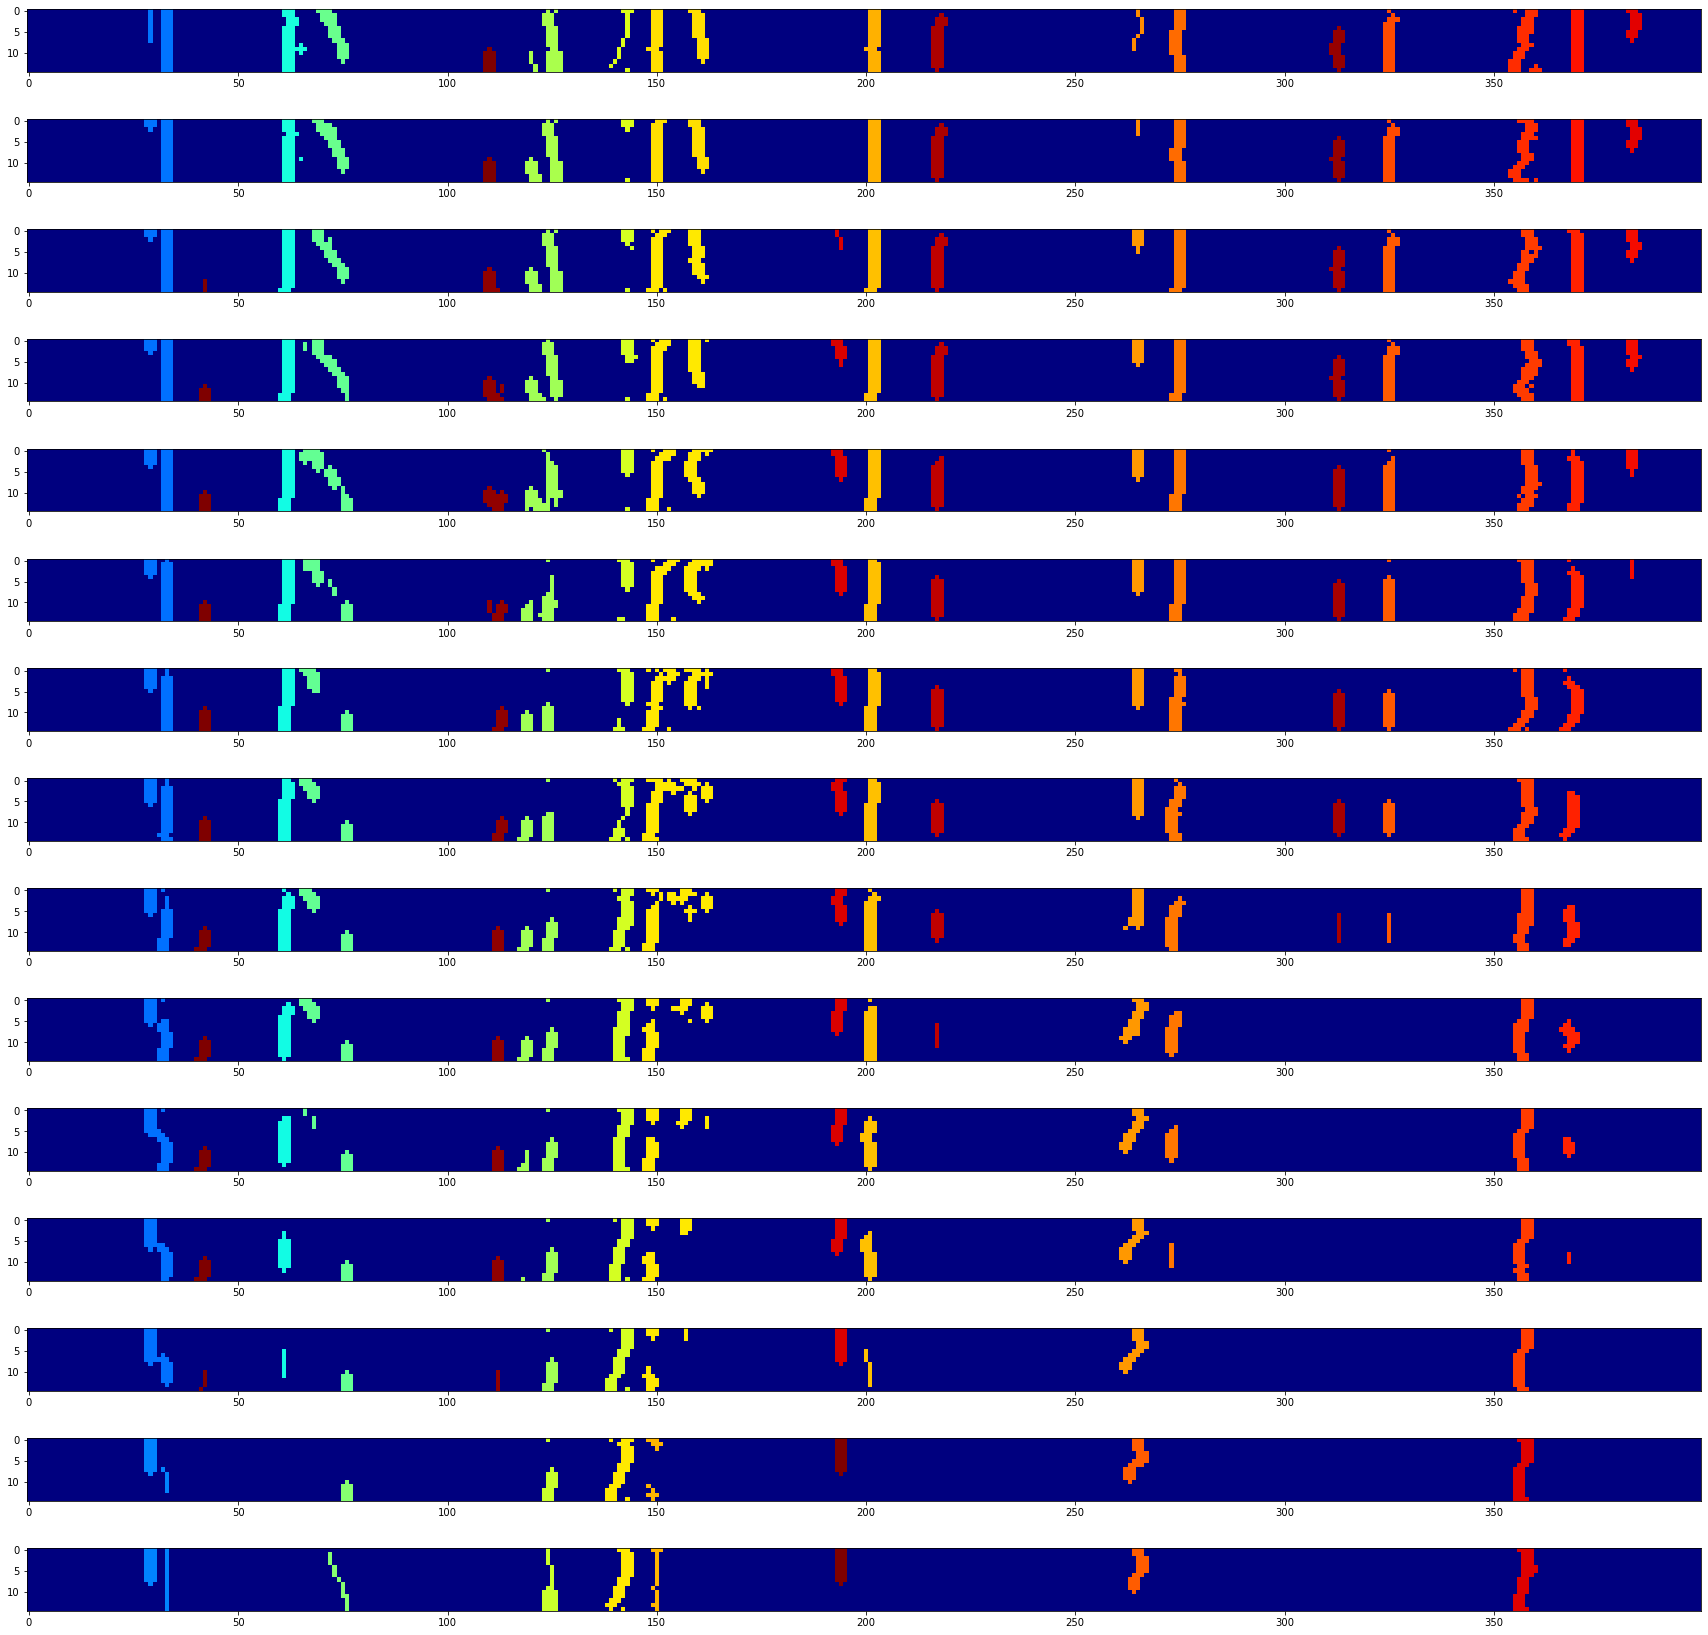

In [618]:
plot_cuts(labeled, axis = 1)

### Test cases for the visualization:

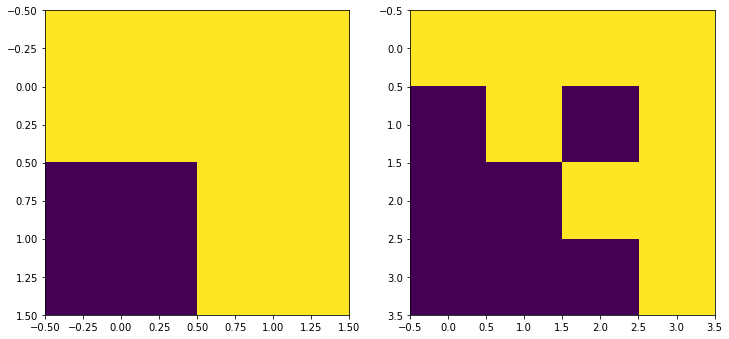

In [1726]:
ta = np.ones((3, 2, 2))

ta[:, 1, 0] = 0

plt.rcParams["figure.figsize"]=(12, 12)
a, b = 1, 2

plt.subplot(a, b, 1)
plt.imshow(ta.sum(axis = 0))

plt.subplot(a, b, 2)
ttmp = np.einsum("kij, klm->ijlm", ta, ta)
plt.imshow((gridstack(ttmp)))

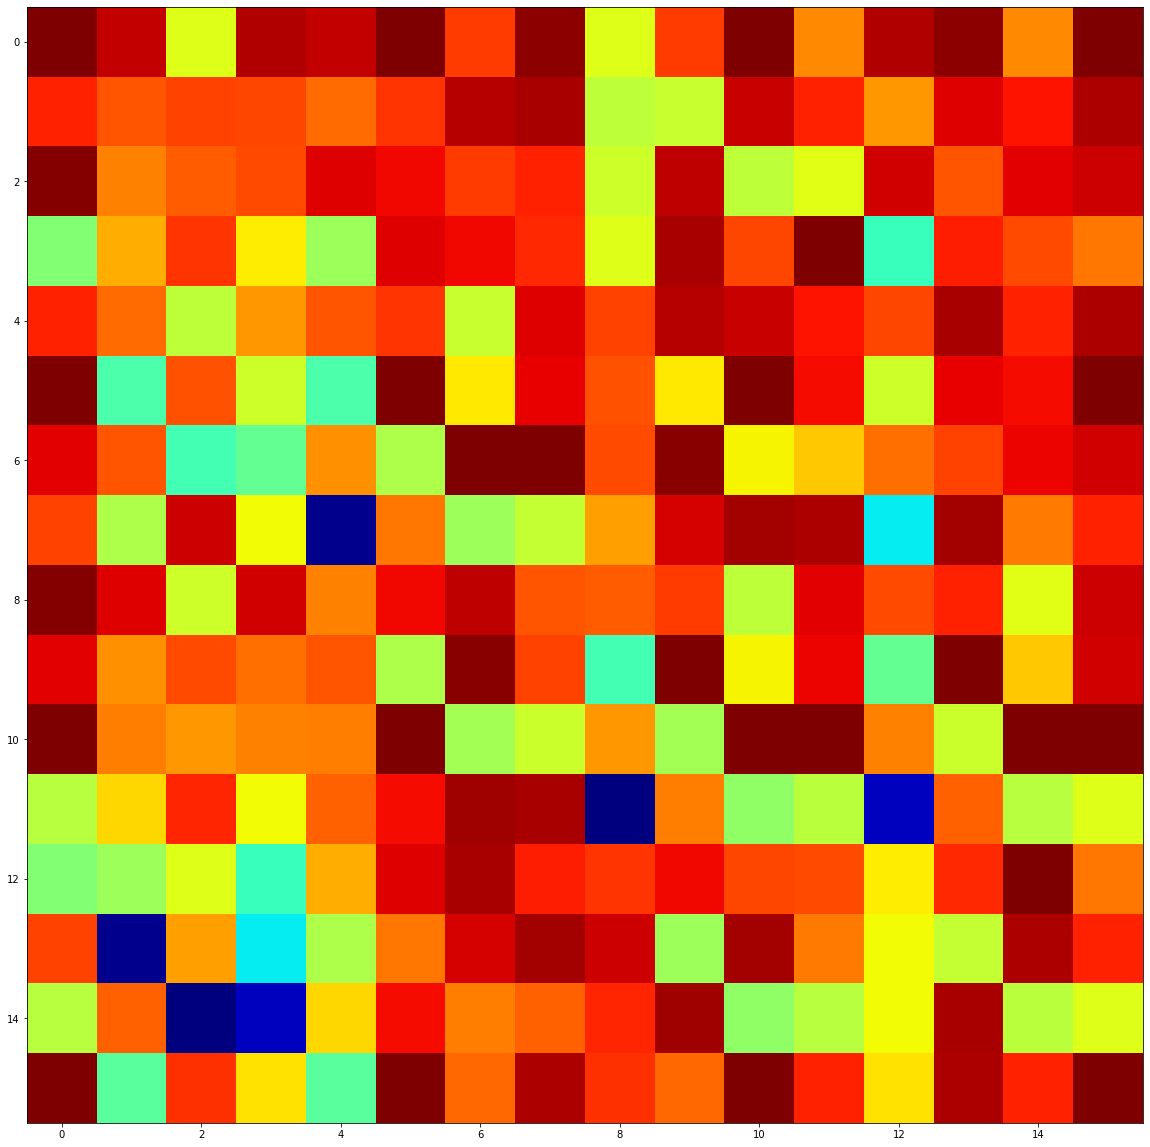

In [1841]:
ta = np.random.rand(3, 4, 4)
ta[0, 3, 0] = 0
#ta[1, 3, 0] = 0
ta[2, 3, 0] = 0
ta[:, 2, 1] *= 10


scale = np.log(np.mean(ta, axis = (1, 2)))

activations_n1 = ta * 2 # / scale[:, None, None]
activations_n1[:, 0, 1] = 2
ttmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

norm = np.linalg.norm(activations_n1, axis = 0)

norm4d = np.einsum("ij, kl->ijkl", norm, norm)

tmp_csim = ttmp / (norm4d + 1e-10)

plt.imshow((gridstack(tmp_csim)), cmap = 'jet')

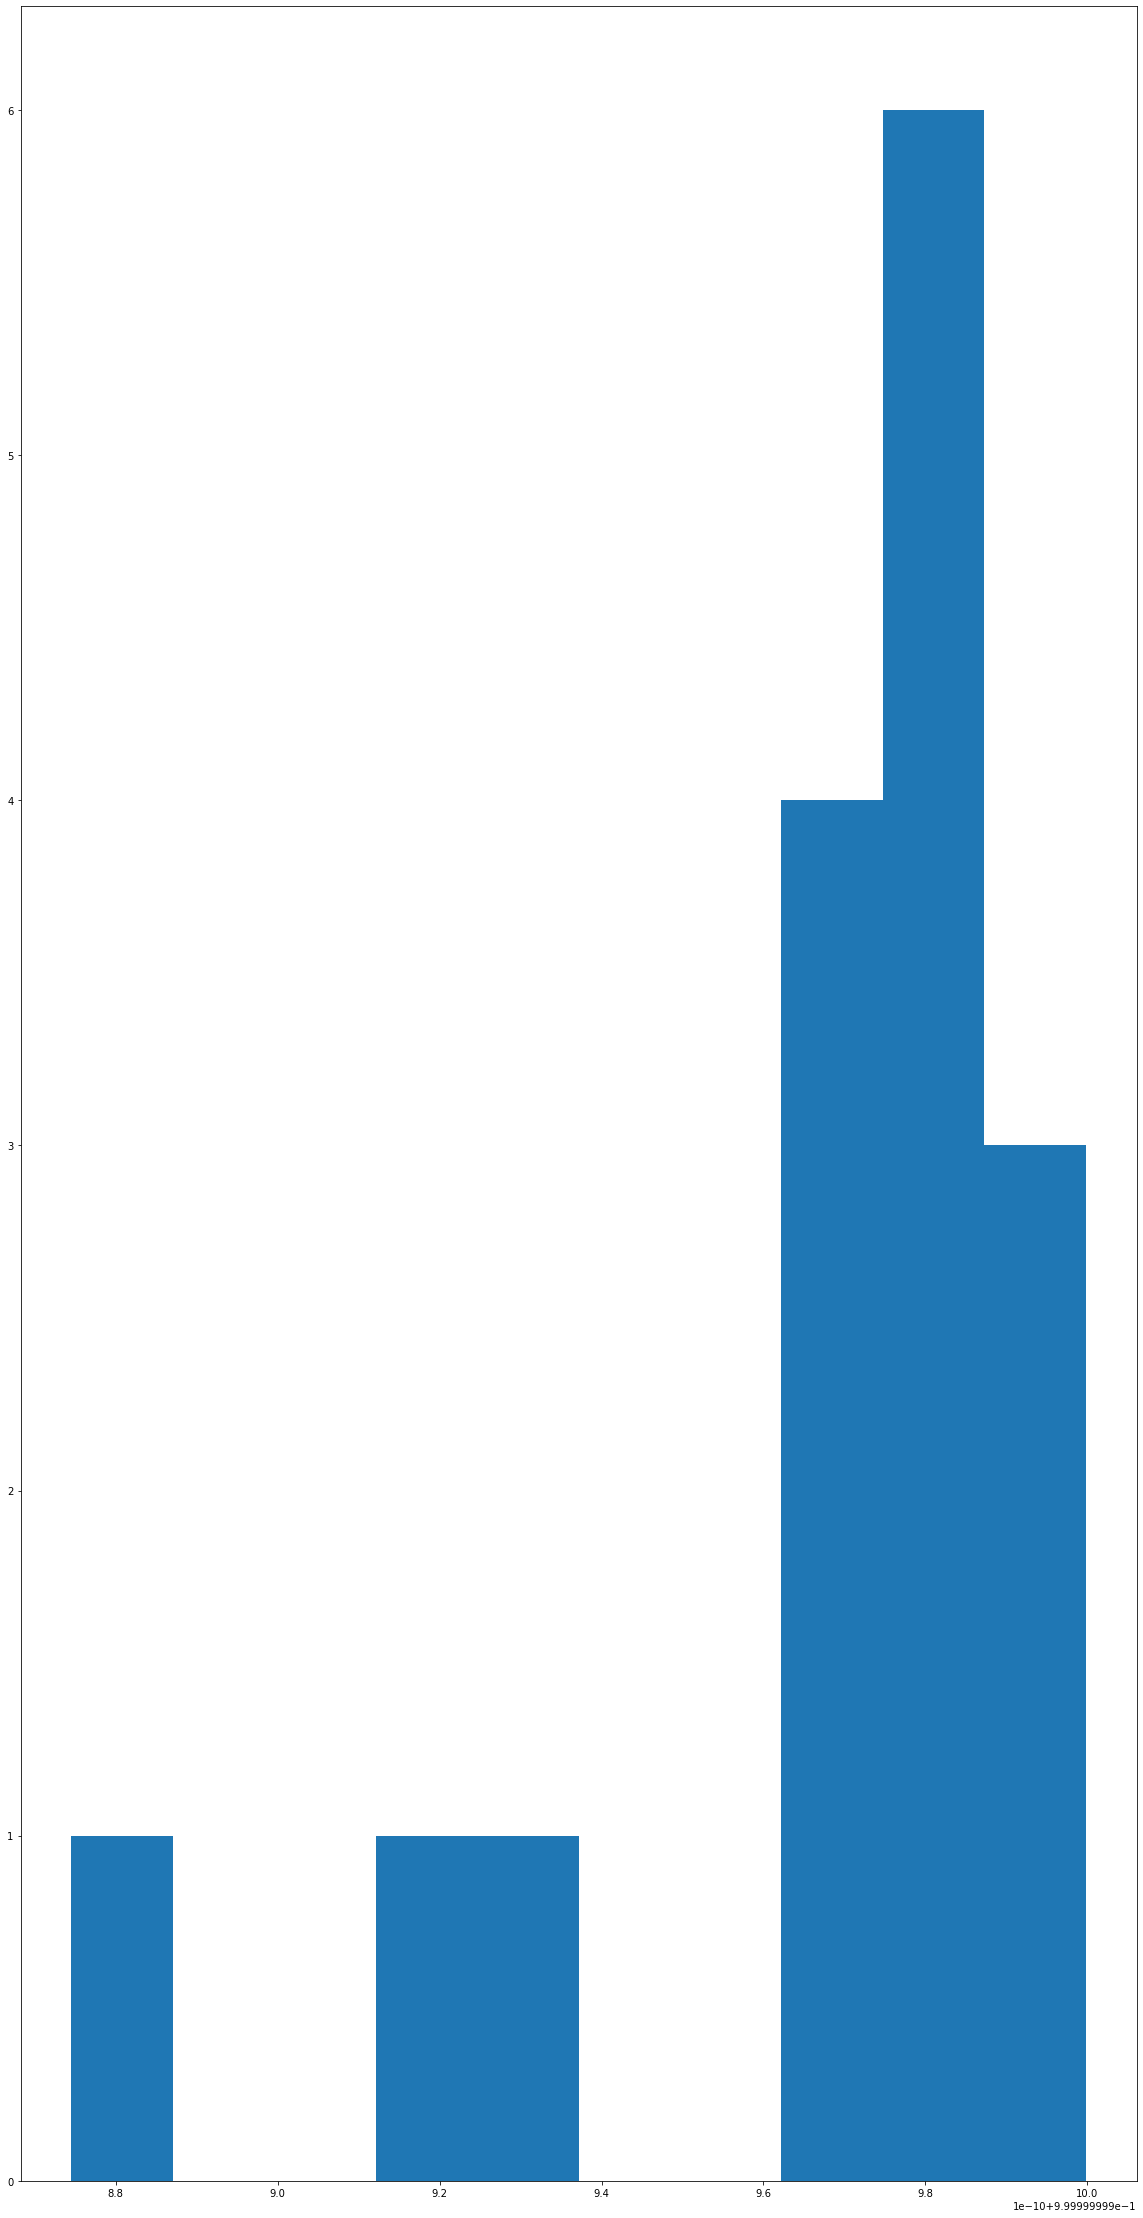

In [1842]:
plt.hist(tmp_csim.max(axis = (0, 1)).ravel(), bins = 10);

In [226]:
%pdb

Automatic pdb calling has been turned ON


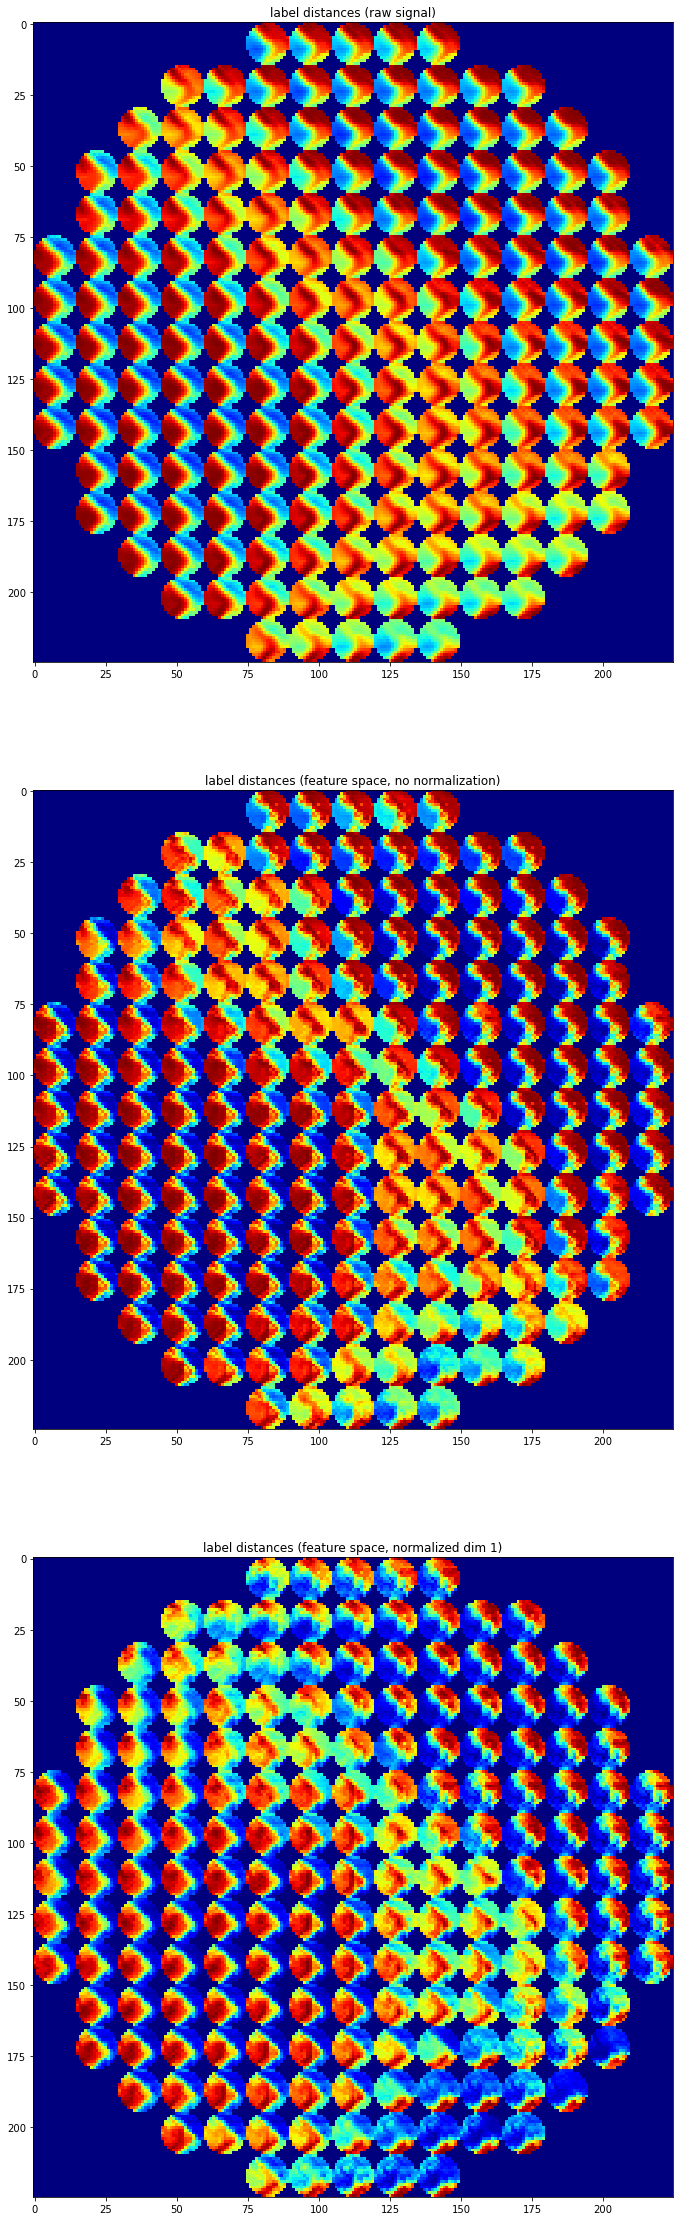

In [22]:
plt.rcParams["figure.figsize"]=(20, 40)

a, b, = 3, 1
similarity_plot_row(csim3d, "label", swap3d(patterns), activations, activations_n1, 
                        activations_n1_log = None, offset = 0, swapper = None,
                   plotter = lambda arr: simple_heatmap(gridstack(arr)))

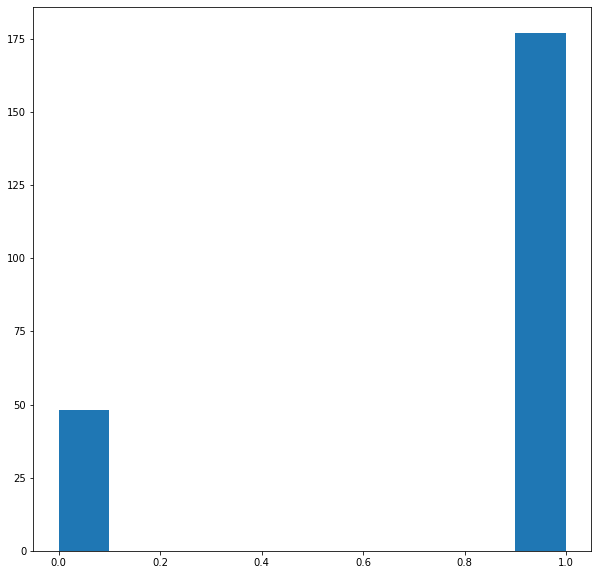

In [1789]:
plt.hist(tmp_csim.max(axis = (0, 1)).ravel());

### Compare to a wrong way of calculating the similarity matrix:

In [1675]:
csim2 = l2_pairs(activations.reshape(16, -1).T).T

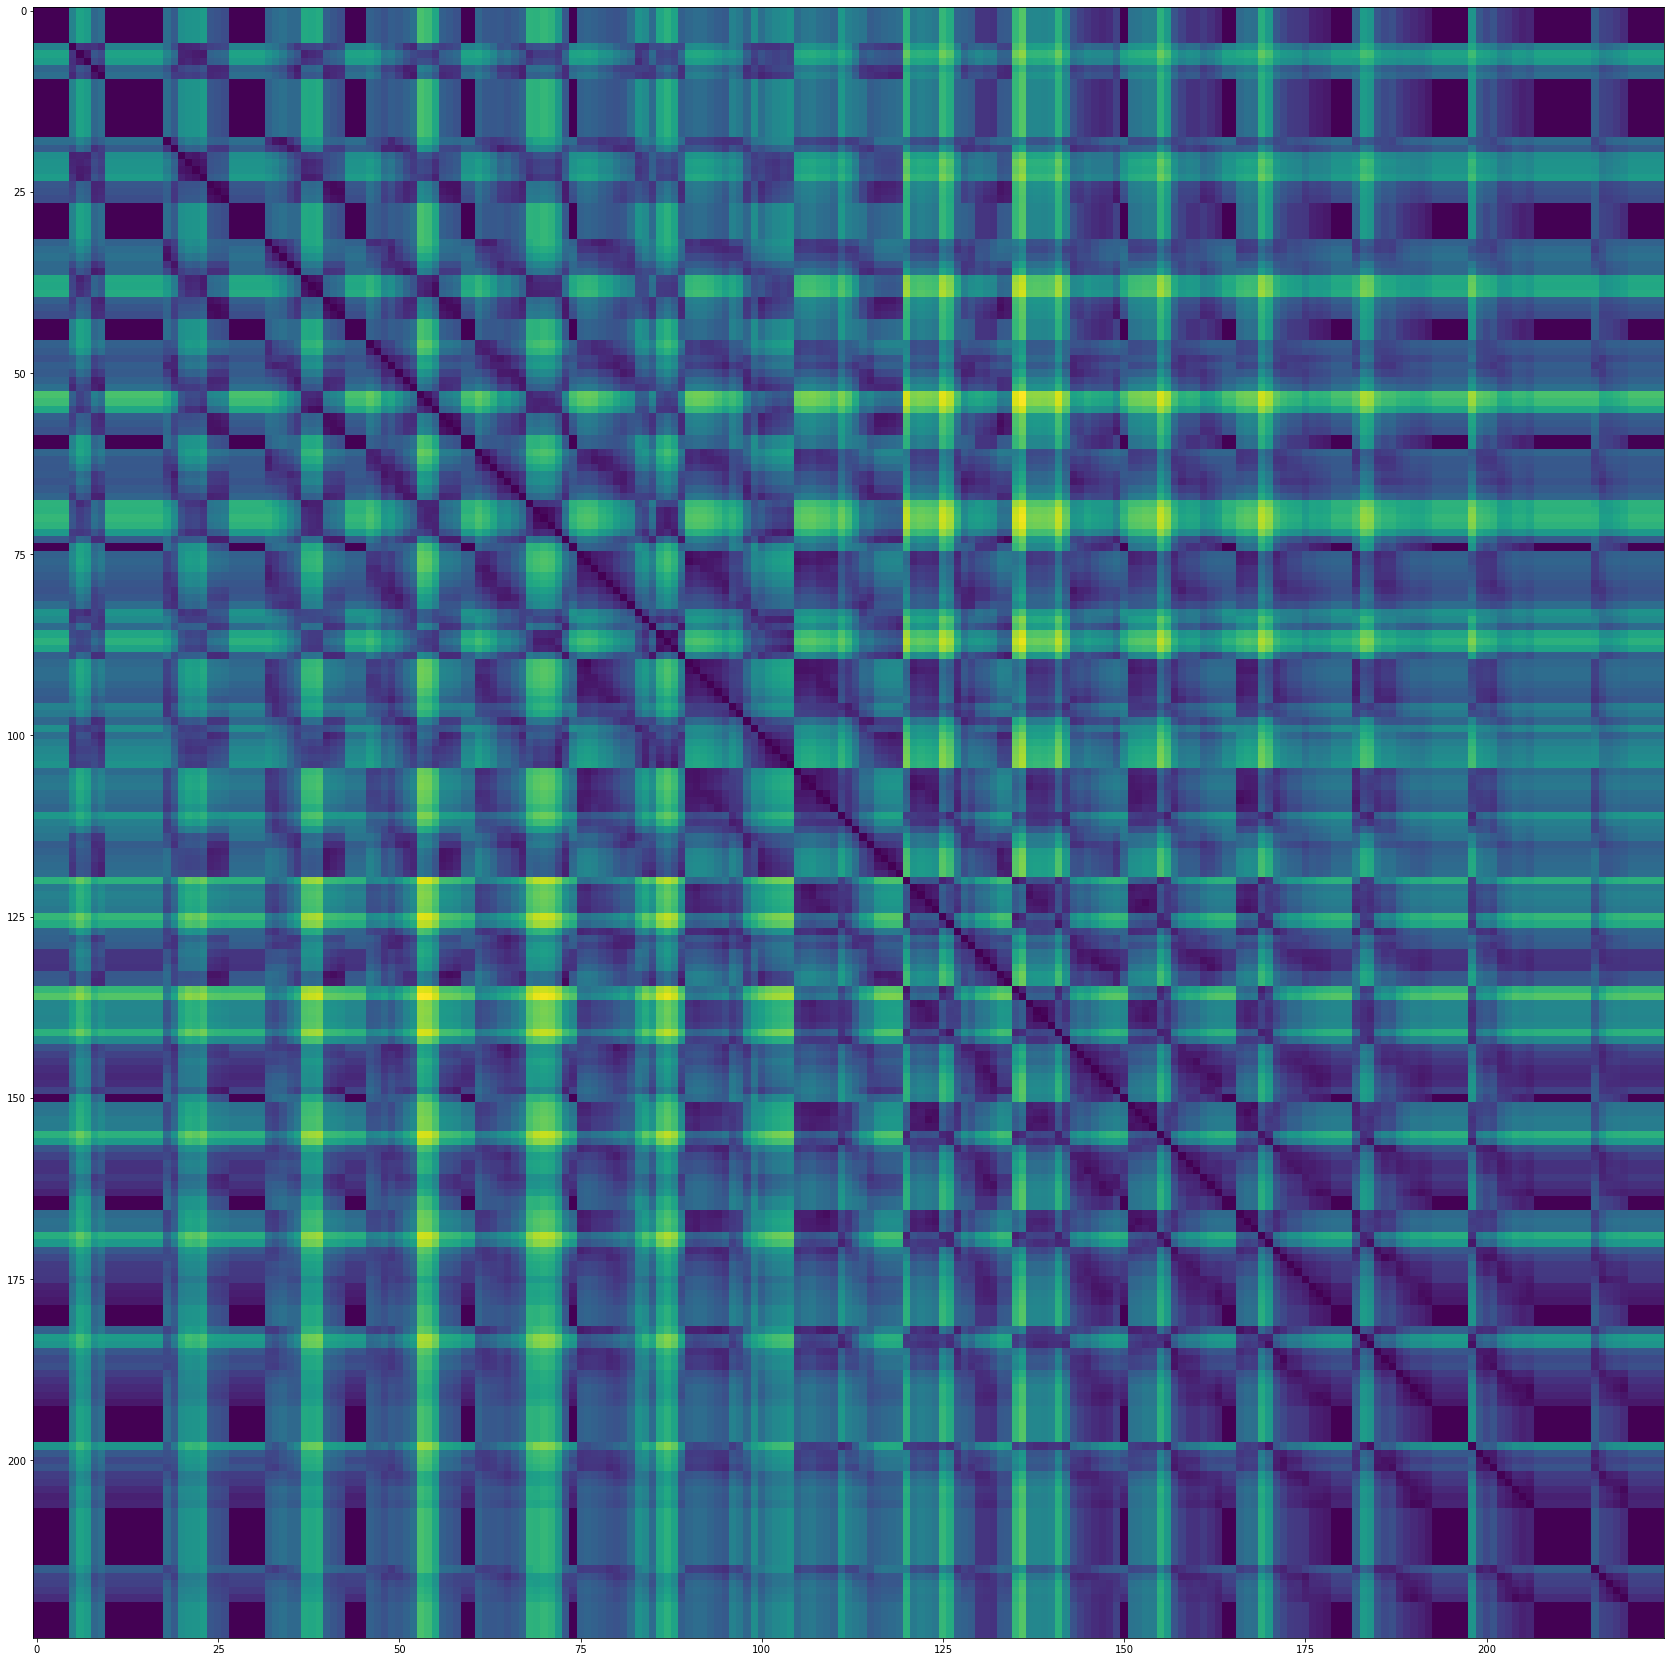

In [1677]:
plt.imshow(csim2)

In [397]:
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import scipy.cluster.vq as scv

In [514]:
arr=plt.imread('/Users/ollie/Downloads/Outlook-xrjjtowh (1).jpg') / 255

alpha = np.ones(arr.shape[:2] + (1,))

arr = np.dstack((arr, alpha))